## Host Ecosystem Analysis: Does Scale Compromise Quality?

Thessaloniki's short-term rental market has grown rapidly, raising questions about whether professional operators enhance or diminish the guest experience. Understanding host ecosystem dynamics is crucial for evidence-based tourism policy.

### Research Questions
1. Do multi-property hosts achieve different guest engagement patterns than smaller operators?
2. Does the current host ecosystem structure benefit the rental market?
3. Is there a "sweet spot" in host portfolio size for optimal performance?

### Host Categorization Framework

| Category | Listings | Profile |
|----------|----------|---------|
| **Individual** | 1 | Casual/occasional hosts, often sharing personal space |
| **Small Multi** | 2-3 | Semi-professional, transitioning to STR business |
| **Medium Multi** | 4-10 | Professional operators, dedicated STR management |
| **Large Multi** | 11+ | Commercial/corporate operators, scaled operations |

### Key Finding Preview
> *Mid-scale professional hosts (2-10 listings) achieve the optimal balance of operational efficiency and guest experience quality. Large commercial operators (11+ listings) show signs of a "quantity over quality" approach — higher market share but lower quality scores.

<hr>

In [61]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy import stats

sys.path.insert(0, str(Path.cwd().parent))
from scripts.eda_functions import (
    analyze_numeric_variable,
    analyze_categorical_variable,
    analyze_categorical_numerical,
    analyze_categorical_categorical
    )

In [62]:
data_path = Path.cwd().parent / "data" / "processed"
df = pd.read_parquet(data_path / "listings_regular_license.parquet", engine="pyarrow")
pd.set_option('display.float_format', '{:,.2f}'.format)
print(f"Dataset shape: {df.shape}")

Dataset shape: (4124, 54)


In [63]:
# Set global style and color palette
sns.set_theme(style="whitegrid")
sns.set_palette("Paired")  # or "husl", "muted", "pastel", "deep", "colorblind"

# For matplotlib defaults
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("Paired"))

In [64]:
CATEGORY_ORDER = ['Individual (1)', 'Small Multi (2-3)', 'Medium Multi (4-10)', 'Large Multi (11+)']

# Color mapping for host categories
host_colors = {
    'Individual (1)': '#D7BD92',
    'Small Multi (2-3)': '#81B29A',
    'Medium Multi (4-10)': '#127C7F',
    'Large Multi (11+)': '#3D405B'
}

<hr>

## Who Controls the Market?

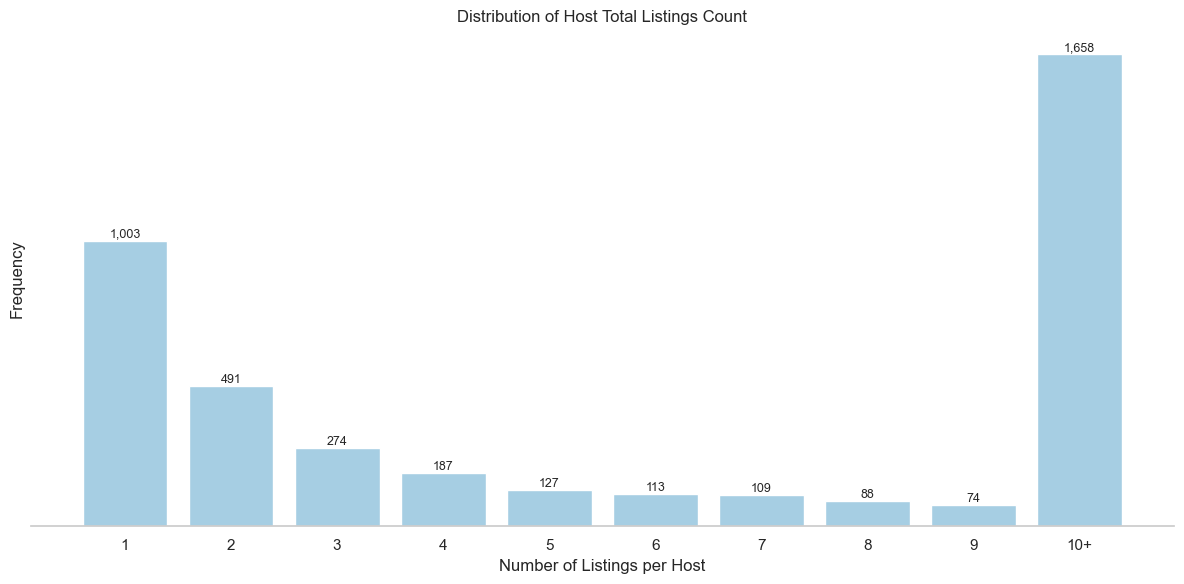

In [65]:
# Create binned histogram for host_total_listings_count
bins = list(range(1, 11)) + [df["host_total_listings_count"].max() + 1]
labels = [str(i) for i in range(1, 10)] + ["10+"]

df["listings_bin"] = pd.cut(df["host_total_listings_count"], bins=bins, labels=labels, right=False)
bin_counts = df["listings_bin"].value_counts().sort_index()

plt.figure(figsize=(12, 6))
bars = plt.bar(bin_counts.index, bin_counts.values)
plt.xlabel('Number of Listings per Host')
plt.ylabel('Frequency')
plt.title('Distribution of Host Total Listings Count')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom', fontsize=9)

# Remove y-axis ticks and clean up chart
plt.yticks([])
sns.despine(left=True)
plt.grid(False)

plt.tight_layout()
plt.show()

# Clean up temporary column
df.drop(columns=["listings_bin"], inplace=True)

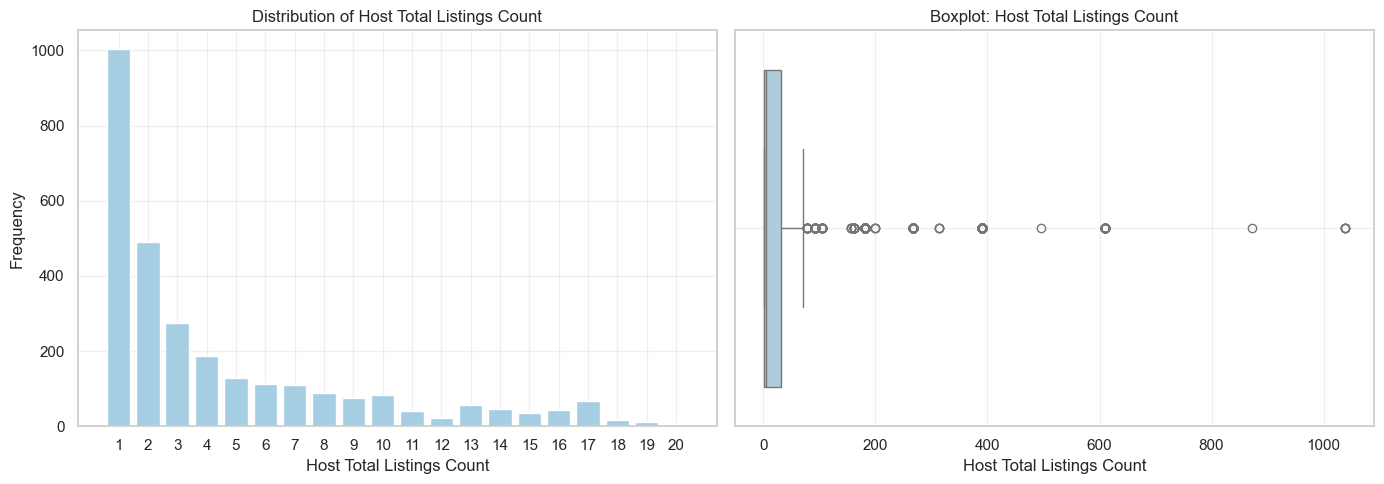

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
listing_counts = df["host_total_listings_count"].value_counts().sort_index().head(20)
axes[0].bar(listing_counts.index.astype(str), listing_counts.values)
axes[0].set_xlabel('Host Total Listings Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Host Total Listings Count')
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(True, alpha=0.3)

# Boxplot
sns.boxplot(x=df["host_total_listings_count"], ax=axes[1])
axes[1].set_xlabel('Host Total Listings Count')
axes[1].set_title('Boxplot: Host Total Listings Count')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [67]:
print("Host Total Listings Count Summary:")
print(df["host_total_listings_count"].describe())

Host Total Listings Count Summary:
count   4,124.00
mean       58.20
std       124.29
min         1.00
25%         2.00
50%         5.00
75%        32.00
max     1,038.00
Name: host_total_listings_count, dtype: Float64


In [68]:
# Host category distribution
category_counts = df["host_category"].value_counts()
category_proportions = df["host_category"].value_counts(normalize=True).round(3)

print("="*60)
print("HOST CATEGORY DISTRIBUTION")
print("="*60)
print(f"\nTotal listings: {len(df):,}")
print("\nMarket share (%):")
for category, proportion in category_proportions.items():
    count = category_counts[category]
    print(f"  {category:20s}: {proportion*100:5.1f}% ({count:,} listings)")

HOST CATEGORY DISTRIBUTION

Total listings: 4,124

Market share (%):
  Large Multi (11+)   :  38.2% (1,576 listings)
  Individual (1)      :  24.3% (1,003 listings)
  Medium Multi (4-10) :  18.9% (780 listings)
  Small Multi (2-3)   :  18.5% (765 listings)


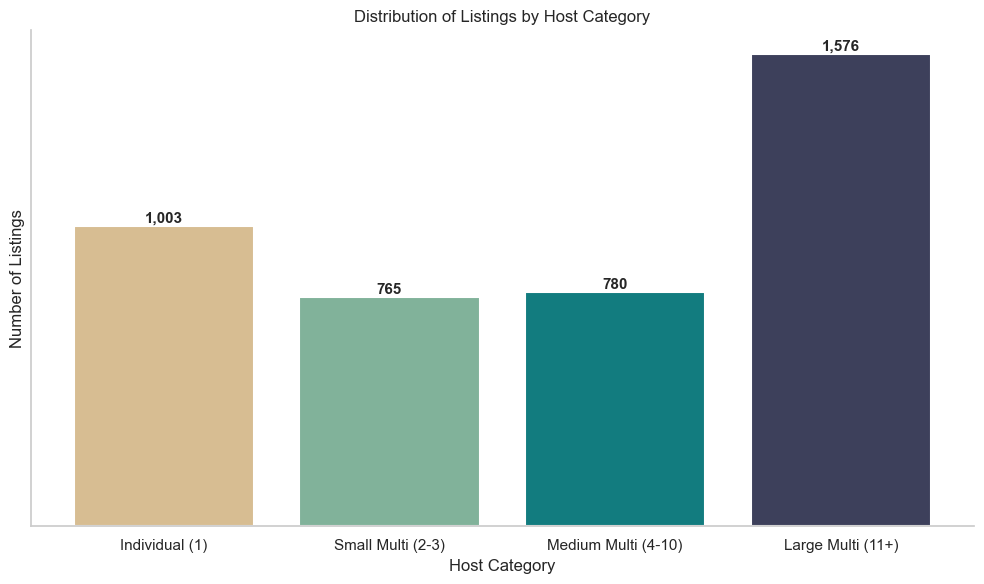

In [69]:
# Bar chart for Host Category distribution with custom colors
host_category_counts = df["host_category"].value_counts().reindex(CATEGORY_ORDER)

plt.figure(figsize=(10, 6))
colors = [host_colors[cat] for cat in host_category_counts.index]
bars = plt.bar(host_category_counts.index, host_category_counts.values, color=colors, edgecolor='white', linewidth=1.5)
plt.xlabel('Host Category')
plt.ylabel('Number of Listings')
plt.title('Distribution of Listings by Host Category')
plt.xticks(rotation=0)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax = plt.gca()
ax.set_yticks([])
sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()


In [70]:
# Count listings per host in our dataset
host_listing_counts = df.groupby('host_id').size().sort_values(ascending=False)

# Total listings in dataset
total_listings = len(df)

# Total unique hosts
n_hosts = len(host_listing_counts)

# Top 10 hosts
top_10_hosts = host_listing_counts.head(10)
top_10_share = top_10_hosts.sum() / total_listings * 100

# Top 1%, 5%, 10% of hosts
top_1pct_count = max(1, int(n_hosts * 0.01))
top_5pct_count = max(1, int(n_hosts * 0.05))
top_10pct_count = max(1, int(n_hosts * 0.10))

top_1pct = host_listing_counts.head(top_1pct_count).sum() / total_listings * 100
top_5pct = host_listing_counts.head(top_5pct_count).sum() / total_listings * 100
top_10pct = host_listing_counts.head(top_10pct_count).sum() / total_listings * 100

print("=" * 60)
print("MARKET CONCENTRATION ANALYSIS")
print("=" * 60)
print(f"\nTotal listings: {total_listings:,}")
print(f"Total unique hosts: {n_hosts:,}")
print(f"Average listings per host (Thessaloniki listings only): {total_listings/n_hosts:.2f}")

print(f"\n Top Host Concentration:")
print(f"   Top 10 hosts control: {top_10_share:.1f}% of listings ({top_10_hosts.sum():,} listings)")
print(f"   Top 1% of hosts ({top_1pct_count:,}) control: {top_1pct:.1f}% of listings")
print(f"   Top 5% of hosts ({top_5pct_count:,}) control: {top_5pct:.1f}% of listings")
print(f"   Top 10% of hosts ({top_10pct_count:,}) control: {top_10pct:.1f}% of listings")

print(f"\nTop 5 Hosts by Listing Count:")
for i, (host, count) in enumerate(top_10_hosts.head(5).items(), 1):
    pct = count / total_listings * 100
    print(f"   {i}. {host}: {count} listings ({pct:.1f}%)")

MARKET CONCENTRATION ANALYSIS

Total listings: 4,124
Total unique hosts: 1,913
Average listings per host (Thessaloniki listings only): 2.16

 Top Host Concentration:
   Top 10 hosts control: 19.0% of listings (784 listings)
   Top 1% of hosts (19) control: 24.1% of listings
   Top 5% of hosts (95) control: 41.4% of listings
   Top 10% of hosts (191) control: 50.5% of listings

Top 5 Hosts by Listing Count:
   1. HOST_4497DA: 282 listings (6.8%)
   2. HOST_569BB2: 177 listings (4.3%)
   3. HOST_CCD9F4: 79 listings (1.9%)
   4. HOST_C1D911: 46 listings (1.1%)
   5. HOST_044261: 41 listings (1.0%)


#### **Main Findings**

* Large Multi hosts (11+) dominate with 1,576 listings (38% market share) — the single largest category.
* Individual hosts contribute 1,003 listings (24% market share) — nearly a quarter of supply.
* Medium Multi (4-10) and Small Multi (2-3) are roughly equal: 780 and 765 listings respectively (~19% each).
* Long tail of mega-operators: 1,658 listings come from hosts with 10+ properties.
* The boxplot reveals extreme outliers — some hosts control 200-1,000+ listings (not only in Thessaloniki but globally).
* A single host holds almost 7% of total listings of Thessaloniki.

#### **Comment:** 

There is a clear structure in host types, while the majority of hosts are small operators, the biggest portion of listings is controlled by large multi-property hosts, indicating a trend towards professionalization in the market.

<hr>

## Does Scale Drive Performance?

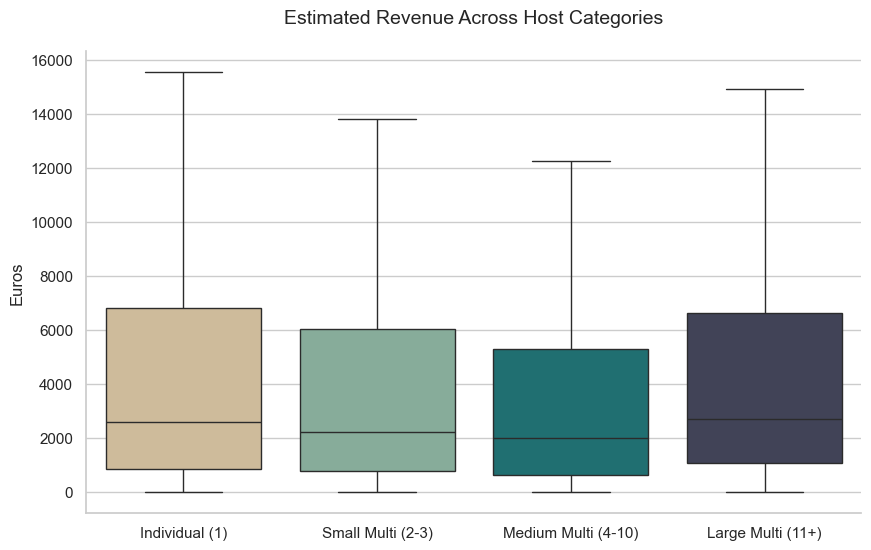

In [71]:
# Create boxplot with host category colors
plt.figure(figsize=(10, 6))

# Create the plot
sns.boxplot(
    data=df,
    x='host_category',
    y='estimated_revenue_l365d',
    order=CATEGORY_ORDER,
    palette=host_colors,  # Use palette instead of color
    showfliers=False,  # Hides extreme outliers to focus on the main distribution,
    hue=df["host_category"]
)
    
# Clean up for the report
plt.title('Estimated Annual Revenue Across Host Categories', fontsize=14, pad=20)
plt.xlabel('')
plt.ylabel('Euros')
sns.despine()
    
plt.show()


In [72]:
# Kruskal-Wallis test with epsilon-squared effect size

groups = [df[df['host_category'] == cat]['estimated_revenue_l365d'].dropna() for cat in CATEGORY_ORDER]

# Print descriptive statistics for each host category
print("="*60)
print("ESTIMATED REVENUE BY HOST CATEGORY - DESCRIPTIVE STATISTICS")
print("="*60)
for cat, group in zip(CATEGORY_ORDER, groups):
    print(f"\n{cat}:")
    print(f"  Mean:   €{group.mean():,.2f}")
    print(f"  Median: €{group.median():,.2f}")
    print(f"  Std:    €{group.std():,.2f}")
    print(f"  N:      {len(group):,}")

# Kruskal-Wallis test (non-parametric)
h_stat, p_value = stats.kruskal(*groups)

# Calculate epsilon-squared (ε²) 
# Formula: ε² = H / (n - 1)
n_total = sum(len(g) for g in groups)
epsilon_squared = h_stat / (n_total - 1)

# Interpretation thresholds for epsilon-squared
if epsilon_squared < 0.01:
    effect_interp = "negligible"
elif epsilon_squared < 0.06:
    effect_interp = "small"
elif epsilon_squared < 0.14:
    effect_interp = "medium"
else:
    effect_interp = "large"

print("="*60)
print("Estimated Revenue by Host Category (Non-parametric Test)")
print("="*60)
print(f"\nKruskal-Wallis H = {h_stat:.3f}, p = {p_value:.6f}")
print(f"Epsilon-squared (ε²) = {epsilon_squared:.4f} ({effect_interp} effect)")

ESTIMATED REVENUE BY HOST CATEGORY - DESCRIPTIVE STATISTICS

Individual (1):
  Mean:   €4,437.34
  Median: €2,592.00
  Std:    €4,954.44
  N:      946

Small Multi (2-3):
  Mean:   €4,271.97
  Median: €2,220.00
  Std:    €5,767.10
  N:      727

Medium Multi (4-10):
  Mean:   €3,769.52
  Median: €1,980.00
  Std:    €4,675.11
  N:      737

Large Multi (11+):
  Mean:   €4,860.65
  Median: €2,688.00
  Std:    €6,848.41
  N:      1,497
Estimated Revenue by Host Category (Non-parametric Test)

Kruskal-Wallis H = 26.963, p = 0.000006
Epsilon-squared (ε²) = 0.0069 (negligible effect)


#### **Main Findings**

* Scale does not guarantee higher revenue per listing. 
* Median annual revenue is comparable across all categories, ranging from €1,980 (Medium Multi) to €2,688 (Large Multi). Although statistically significant ($p < 0.001$), the negligible effect size ($\epsilon^2 = 0.007$) indicates that portfolio size has no practical impact on individual listing performance.

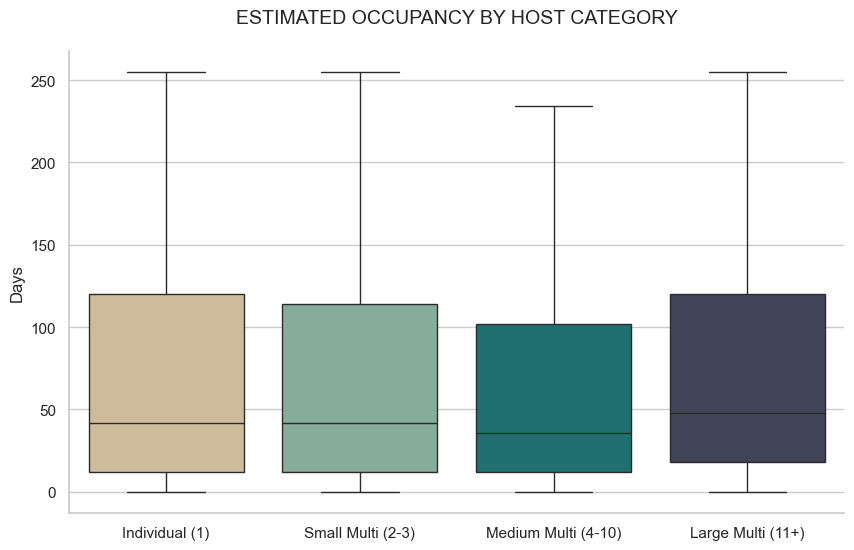

In [73]:
plt.figure(figsize=(10, 6))
    
# Create the plot
sns.boxplot(
    data=df,
    x='host_category',
    y='estimated_occupancy_l365d',
    order=CATEGORY_ORDER,
    palette=host_colors,  # Use palette instead of color
    showfliers=False,  # Hides extreme outliers to focus on the main distribution,
    hue=df["host_category"]
)
    
# Clean up for the report
plt.title('Estimated Annual Occupancy Across Host Categories', fontsize=14, pad=20)
plt.xlabel('')
plt.ylabel('Days')
sns.despine()
    
plt.show()

In [74]:
# Kruskal-Wallis test with epsilon-squared effect size

groups = [df[df['host_category'] == cat]['estimated_occupancy_l365d'].dropna() for cat in CATEGORY_ORDER]

# Print descriptive statistics for each host category
print("="*60)
print("ESTIMATED OCCUPANCY BY HOST CATEGORY - DESCRIPTIVE STATISTICS")
print("="*60)
for cat, group in zip(CATEGORY_ORDER, groups):
    print(f"\n{cat}:")
    print(f"  Mean:   {group.mean():,.2f}")
    print(f"  Median: {group.median():,.2f}")
    print(f"  Std:    {group.std():,.2f}")

# Kruskal-Wallis test (non-parametric)
h_stat, p_value = stats.kruskal(*groups)

# Calculate epsilon-squared (ε²) 
# Formula: ε² = H / (n - 1)
n_total = sum(len(g) for g in groups)
epsilon_squared = h_stat / (n_total - 1)

# Interpretation thresholds for epsilon-squared
if epsilon_squared < 0.01:
    effect_interp = "negligible"
elif epsilon_squared < 0.06:
    effect_interp = "small"
elif epsilon_squared < 0.14:
    effect_interp = "medium"
else:
    effect_interp = "large"

print("="*60)
print("ESTIMATED OCCUPANCY BY HOST CATEGORY (Non-parametric Test)")
print("="*60)
print(f"\nKruskal-Wallis H = {h_stat:.3f}, p = {p_value:.6f}")
print(f"Epsilon-squared (ε²) = {epsilon_squared:.4f} ({effect_interp} effect)")

ESTIMATED OCCUPANCY BY HOST CATEGORY - DESCRIPTIVE STATISTICS

Individual (1):
  Mean:   €75.14
  Median: €42.00
  Std:    €76.99

Small Multi (2-3):
  Mean:   €71.25
  Median: €42.00
  Std:    €75.96

Medium Multi (4-10):
  Mean:   €66.23
  Median: €36.00
  Std:    €73.99

Large Multi (11+):
  Mean:   €77.78
  Median: €48.00
  Std:    €76.88
ESTIMATED OCCUPANCY BY HOST CATEGORY (Non-parametric Test)

Kruskal-Wallis H = 24.665, p = 0.000018
Epsilon-squared (ε²) = 0.0060 (negligible effect)


#### **Main Findings**

* Occupancy shows no meaningful variation across host categories. 
* Despite statistical significance ($p < 0.001$), the negligible effect size ($\epsilon^2 = 0.006$) suggests a competitive market structure where scale provides no inherent advantage in attracting bookings.

### **Comment:** 

One would expect that professional operators (Large Multi) would have higher occupancy due to professional advantages like pricing optimizations tools, more aggressive marketing or better management systems, but this doesn't seem to be the case here.

<hr>

## Does scale equal quality?

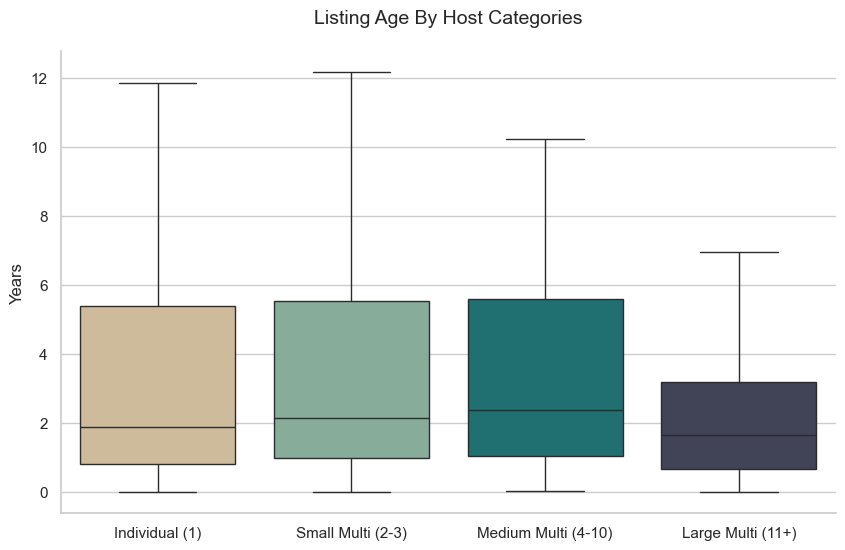

In [75]:
plt.figure(figsize=(10, 6))
    
# Create the plot
sns.boxplot(
    data=df,
    x='host_category',
    y='listing_age_years',
    order=CATEGORY_ORDER,
    palette=host_colors,  # Use palette instead of color
    showfliers=False,  # Hides extreme outliers to focus on the main distribution,
    hue=df["host_category"]
)
    
# Clean up for the report
plt.title('Listing Age By Host Categories', fontsize=14, pad=20)
plt.xlabel('')
plt.ylabel('Years')
sns.despine()
    
plt.show()

In [ ]:
# Kruskal-Wallis test with epsilon-squared effect size

groups = [df[df['host_category'] == cat]['listing_age_years'].dropna() for cat in CATEGORY_ORDER]

# Print descriptive statistics for each host category
print("="*60)
print("LISTING AGE (YEARS) BY HOST CATEGORY - DESCRIPTIVE STATISTICS")
print("="*60)
for cat, group in zip(CATEGORY_ORDER, groups):
    print(f"\n{cat}:")
    print(f"  Mean:   {group.mean():,.2f}")
    print(f"  Median: {group.median():,.2f}")
    print(f"  Std:    {group.std():,.2f}")

# Kruskal-Wallis test (non-parametric)
h_stat, p_value = stats.kruskal(*groups)

# Calculate epsilon-squared (ε²) 
# Formula: ε² = H / (n - 1)
n_total = sum(len(g) for g in groups)
epsilon_squared = h_stat / (n_total - 1)

# Interpretation thresholds for epsilon-squared
if epsilon_squared < 0.01:
    effect_interp = "negligible"
elif epsilon_squared < 0.06:
    effect_interp = "small"
elif epsilon_squared < 0.14:
    effect_interp = "medium"
else:
    effect_interp = "large"

print("="*60)
print("LISTING AGE (YEARS) BY HOST CATEGORY (Non-parametric Test)")
print("="*60)
print(f"\nKruskal-Wallis H = {h_stat:.3f}, p = {p_value:.6f}")
print(f"Epsilon-squared (ε²) = {epsilon_squared:.4f} ({effect_interp} effect)")

LISTING AGE BY HOST CATEGORY - DESCRIPTIVE STATISTICS

Individual (1):
  Mean:   2.97
  Median: 1.89
  Std:    2.70

Small Multi (2-3):
  Mean:   3.16
  Median: 2.15
  Std:    2.75

Medium Multi (4-10):
  Mean:   3.16
  Median: 2.38
  Std:    2.50

Large Multi (11+):
  Mean:   2.30
  Median: 1.64
  Std:    2.17
LISTING AGE BY HOST CATEGORY (Non-parametric Test)

Kruskal-Wallis H = 81.419, p = 0.000000
Epsilon-squared (ε²) = 0.0197 (small effect)


#### **Main Findings**

* Large Multi hosts show younger listings (median 1.6 years) compared to other categories (median 1.9-2.4 years), suggesting recent market entry by commercial operators.
* While the effect size is small ($\epsilon^2 = 0.02$), this pattern indicates growing professionalization of Thessaloniki's STR market in recent years.

### **Comment:** 

The findings supports a narrative that corporate/commercial operators have expanded recently, which is policy-relevant for:

* Monitoring market concentration trends
* Understanding if regulations prompted or deterred professional entry
* Forecasting future market structure

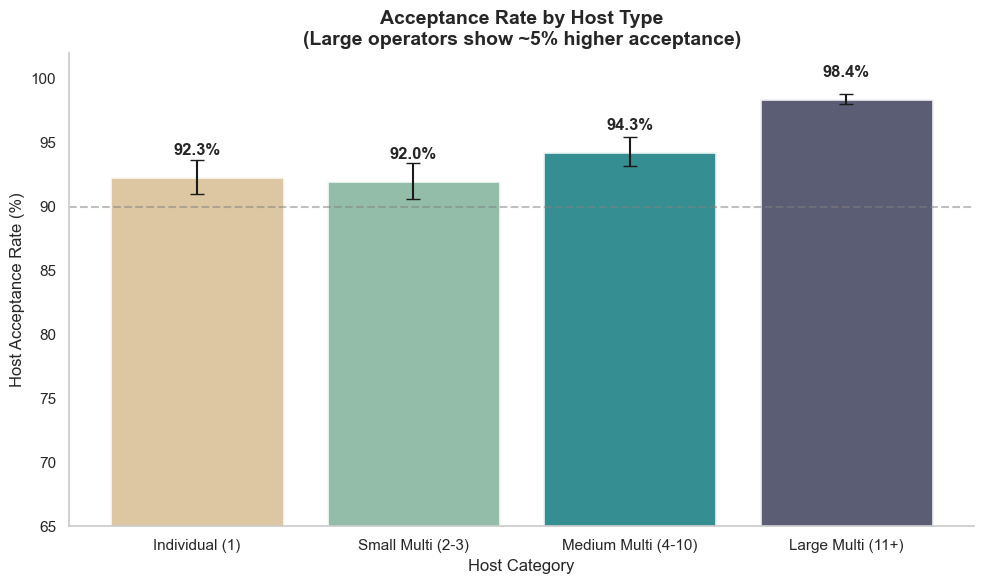

In [77]:
# Calculate means and 95% CI for each group
means = []
cis = []

for cat in CATEGORY_ORDER:
    data = df[df['host_category'] == cat]['host_acceptance_rate'].dropna()
    mean = data.mean()
    ci = 1.96 * data.std() / np.sqrt(len(data))
    means.append(mean * 100)  # Convert to percentage
    cis.append(ci * 100)

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart with custom colors
colors = [host_colors[cat] for cat in CATEGORY_ORDER]
bars = ax.bar(CATEGORY_ORDER, means, yerr=cis, capsize=5, 
              color=colors, edgecolor='white', linewidth=2, alpha=0.85)

# Add value labels
for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
            f'{mean:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Styling
ax.set_ylim(65, 102)
ax.set_ylabel('Host Acceptance Rate (%)', fontsize=12)
ax.set_xlabel('Host Category', fontsize=12)
ax.set_title('Acceptance Rate by Host Type\n(Large operators show ~5% higher acceptance)', 
             fontsize=14, fontweight='bold')

# Add baseline reference
ax.axhline(y=90, color='gray', linestyle='--', alpha=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid(False)
plt.tight_layout()
plt.show()

In [78]:
# Prepare groups
groups = [df[df['host_category'] == cat]['host_acceptance_rate'].dropna() for cat in CATEGORY_ORDER]

# Print descriptive statistics for each host category
print("="*60)
print("ACCEPTANCE RATE BY HOST CATEGORY - DESCRIPTIVE STATISTICS")
print("="*60)
for cat, group in zip(CATEGORY_ORDER, groups):
    print(f"\n{cat}:")
    print(f"  Mean:   €{group.mean():,.2f}")
    print(f"  Median: €{group.median():,.2f}")
    print(f"  Std:    €{group.std():,.2f}")

# Kruskal-Wallis test (non-parametric)
h_stat, p_value = stats.kruskal(*groups)

# Calculate epsilon-squared (ε²) - appropriate effect size for Kruskal-Wallis
# Formula: ε² = H / (n - 1)
n_total = sum(len(g) for g in groups)
epsilon_squared = h_stat / (n_total - 1)

# Interpretation thresholds for epsilon-squared (similar to eta-squared)
if epsilon_squared < 0.01:
    effect_interp = "negligible"
elif epsilon_squared < 0.06:
    effect_interp = "small"
elif epsilon_squared < 0.14:
    effect_interp = "medium"
else:
    effect_interp = "large"

print("="*60)
print("ACCEPTANCE RATE BY HOST CATEGORY (Non-parametric Test)")
print("="*60)
print(f"\nKruskal-Wallis H = {h_stat:.3f}, p = {p_value:.6f}")
print(f"Epsilon-squared (ε²) = {epsilon_squared:.4f} ({effect_interp} effect)")

ACCEPTANCE RATE BY HOST CATEGORY - DESCRIPTIVE STATISTICS

Individual (1):
  Mean:   €0.92
  Median: €1.00
  Std:    €0.20

Small Multi (2-3):
  Mean:   €0.92
  Median: €1.00
  Std:    €0.19

Medium Multi (4-10):
  Mean:   €0.94
  Median: €1.00
  Std:    €0.16

Large Multi (11+):
  Mean:   €0.98
  Median: €1.00
  Std:    €0.08
ACCEPTANCE RATE BY HOST CATEGORY (Non-parametric Test)

Kruskal-Wallis H = 95.664, p = 0.000000
Epsilon-squared (ε²) = 0.0256 (small effect)


#### **Main Findings**

* Large Multi hosts accept ~5% more requests than the other groups, suggesting that large operators are more professional in responsiveness.
* All groups show high acceptance rates (>90%), indicating overall strong acceptance rates.
* Maybe a sign of an "accept all" strategy by some large operators?

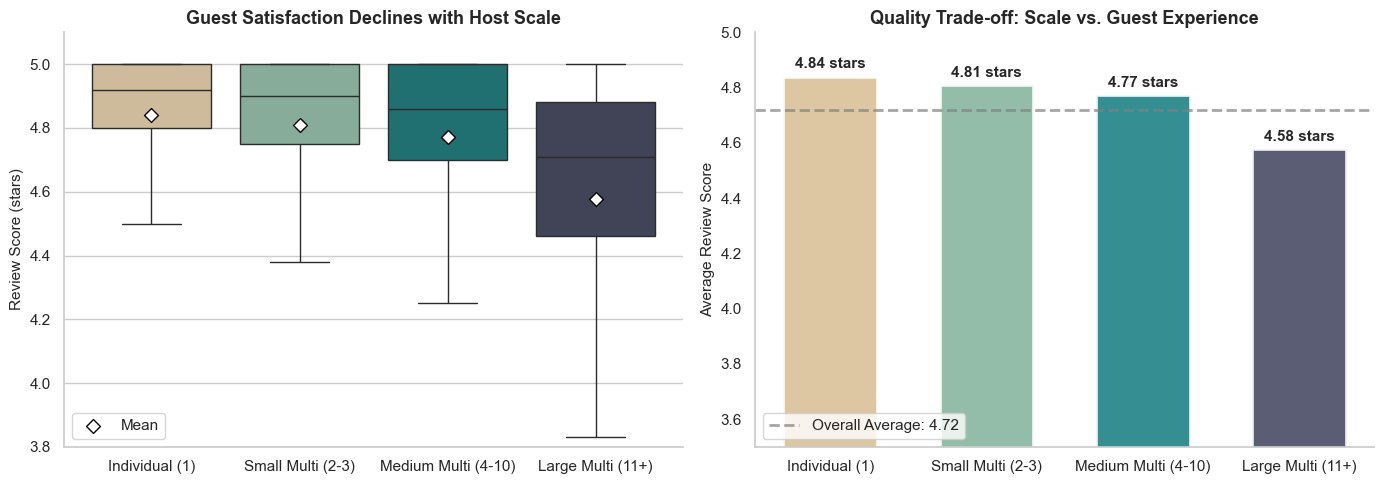

In [79]:
# Visualization: Review Scores by Host Category
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Box plot showing distribution
order = CATEGORY_ORDER

box = sns.boxplot(data=df, x='host_category', y='review_scores_rating', order=order, 
                  hue='host_category', palette=host_colors, legend=False, ax=axes[0],
                  showfliers=False)
axes[0].set_ylabel('Review Score (stars)', fontsize=11)
axes[0].set_xlabel('')
axes[0].set_title('Guest Satisfaction Declines with Host Scale', fontsize=13, fontweight='bold')
axes[0].set_ylim(3.8, 5.1)

# Add mean markers
means = [df[df['host_category'] == cat]['review_scores_rating'].mean() for cat in order]
axes[0].scatter(range(4), means, color='white', s=50, zorder=5, edgecolor='black', marker='D', label='Mean')
axes[0].legend(loc='lower left')

# Right: Bar chart
medians = [df[df['host_category'] == cat]['review_scores_rating'].median() for cat in order]
colors_list = [host_colors[cat] for cat in order]

bars = axes[1].bar(order, means, color=colors_list, width=0.6,
                   edgecolor='white', linewidth=2, alpha=0.85)

# Add value labels
for bar, mean in zip(bars, means):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{mean:.2f} stars', ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[1].set_ylim(3.5, 5.0)
axes[1].set_ylabel('Average Review Score', fontsize=11)
axes[1].set_xlabel('')
axes[1].set_title('Quality Trade-off: Scale vs. Guest Experience', fontsize=13, fontweight='bold')

# Add horizontal line for overall average
overall_avg = df['review_scores_rating'].mean()
axes[1].axhline(y=overall_avg, color='gray', linestyle='--', linewidth=2, alpha=0.7, label=f'Overall Average: {overall_avg:.2f}')
axes[1].legend(loc='lower left')
axes[1].grid(False)

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', rotation=00)

plt.tight_layout()
plt.show()

In [80]:
# Prepare groups
groups = [df[df['host_category'] == cat]['review_scores_rating'].dropna() for cat in CATEGORY_ORDER]

# Print descriptive statistics for each host category
print("="*60)
print("REVIEW SCORES BY HOST CATEGORY - DESCRIPTIVE STATISTICS")
print("="*60)
for cat, group in zip(CATEGORY_ORDER, groups):
    print(f"\n{cat}:")
    print(f"  Mean:   {group.mean():,.2f}")
    print(f"  Median: {group.median():,.2f}")
    print(f"  Std:    {group.std():,.2f}")

# Kruskal-Wallis test (non-parametric)
h_stat, p_value = stats.kruskal(*groups)

# Calculate epsilon-squared (ε²) - appropriate effect size for Kruskal-Wallis
# Formula: ε² = H / (n - 1)
n_total = sum(len(g) for g in groups)
epsilon_squared = h_stat / (n_total - 1)

# Interpretation thresholds for epsilon-squared (similar to eta-squared)
if epsilon_squared < 0.01:
    effect_interp = "negligible"
elif epsilon_squared < 0.06:
    effect_interp = "small"
elif epsilon_squared < 0.14:
    effect_interp = "medium"
else:
    effect_interp = "large"

print("="*60)
print("REVIEW SCORES BY HOST CATEGORY (Non-parametric Test)")
print("="*60)
print(f"\nKruskal-Wallis H = {h_stat:.3f}, p = {p_value:.6f}")
print(f"Epsilon-squared (ε²) = {epsilon_squared:.4f} ({effect_interp} effect)")

REVIEW SCORES BY HOST CATEGORY - DESCRIPTIVE STATISTICS

Individual (1):
  Mean:   4.84
  Median: 4.92
  Std:    0.28

Small Multi (2-3):
  Mean:   4.81
  Median: 4.90
  Std:    0.33

Medium Multi (4-10):
  Mean:   4.77
  Median: 4.86
  Std:    0.32

Large Multi (11+):
  Mean:   4.58
  Median: 4.71
  Std:    0.50
REVIEW SCORES BY HOST CATEGORY (Non-parametric Test)

Kruskal-Wallis H = 483.268, p = 0.000000
Epsilon-squared (ε²) = 0.1172 (medium effect)


#### **Main Findings**

* Review ratings show a gradual decline as host scale increases, from a median of 4.9 stars (Individual) to 4.7 stars (Large Multi).
* Host category has a moderate to large effect on review scores ($\epsilon^2 = 0.12$).
* The variability in ratings also increases with host scale, indicating less consistent guest experiences among larger operators.
* Large Multi hosts ratings drag the average down significantly.

#### **Comment:** 

While professional operators show marginally better operational metrics (acceptance rates), guest satisfaction tells the opposite story: Individual hosts achieve the highest ratings (4.84★) with the most consistency, while large multihosts show both lower scores (4.57★) and greater variability. This 0.27-star gap represents a meaningful quality trade-off that policymakers should consider when evaluating market concentration.

<hr>

## The Superhost Factor


**Note:** The Superhost status is awarded per host based on consistent high performance across key metrics.
Airbnb evaluates a host's performance every 3 months over the past 12 months for all listings across their account.
The key metrics that must be met are:
* \>90% response rate
* \>4.8 review scores
* <1% cancellation rates
* At least 10 reservations or 3 reservations totaling 100+ nights

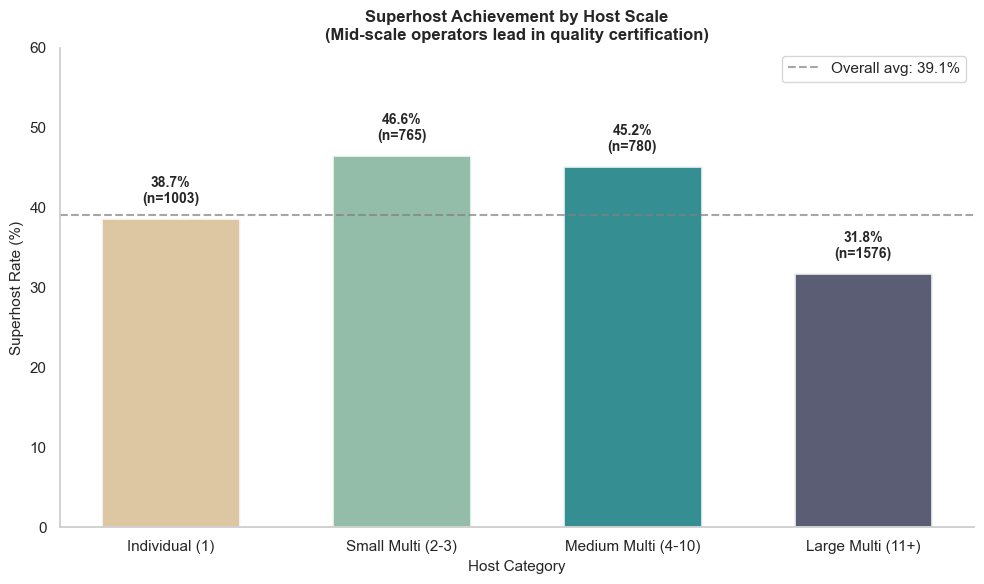

In [81]:
# Visualization: Superhost Rate by Host Category
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate rates
superhost_rates = [df[df['host_category'] == cat]['host_is_superhost'].mean() * 100 for cat in CATEGORY_ORDER]
sample_sizes = [len(df[df['host_category'] == cat]) for cat in CATEGORY_ORDER]

# Bar chart of superhost rates
colors_list = [host_colors[cat] for cat in CATEGORY_ORDER]
bars = ax.bar(CATEGORY_ORDER, superhost_rates, color=colors_list, edgecolor='white', 
              linewidth=2, alpha=0.85, width=0.6)

# Add value labels
for bar, rate, n in zip(bars, superhost_rates, sample_sizes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
            f'{rate:.1f}%\n(n={n})', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Styling
ax.set_ylim(0, 60)
ax.set_xlabel('Host Category', fontsize=11)
ax.set_ylabel('Superhost Rate (%)', fontsize=11)
ax.set_title('Superhost Achievement by Host Scale\n(Mid-scale operators lead in quality certification)', 
             fontsize=12, fontweight='bold')
ax.axhline(y=df['host_is_superhost'].mean()*100, color='gray', linestyle='--', alpha=0.7, 
           label=f"Overall avg: {df['host_is_superhost'].mean()*100:.1f}%")
ax.legend()
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [82]:
# Create contingency table
contingency = pd.crosstab(df['host_category'], df['host_is_superhost'])

# Chi-square test
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

# Cramér's V effect size
n = contingency.sum().sum()
min_dim = min(contingency.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print("="*60)
print("Chi-Square Test: Host Category vs Superhost Status")
print("="*60)
print(f"Chi-square statistic: χ² = {chi2:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value:.6f}")
print(f"Cramér's V: {cramers_v:.3f}")

# Interpret effect size
if cramers_v < 0.1:
    effect = "negligible"
elif cramers_v < 0.2:
    effect = "small"
elif cramers_v < 0.4:
    effect = "moderate"
else:
    effect = "large"
print(f"Effect size interpretation: {effect}")

Chi-Square Test: Host Category vs Superhost Status
Chi-square statistic: χ² = 58.526
Degrees of freedom: 3
P-value: 0.000000
Cramér's V: 0.124
Effect size interpretation: small


#### **Main Findings**

* Mid-scale hosts (2-10 listings) achieve highest superhost rates, an indication that "Growth mindset" operators invest in quality to build reputation.
* Mid-scale segment may represent optimal balance of professionalization and guest experience quality.
* Large Multi hosts have the lowest superhost rate (31,8%), maybe a sign that superhost criteria are harder to meet at scale?

## Does Quality Pay?

In [83]:
# SUMMARY: Superhost Premium Across All Variables
print("="*80)
print("SUMMARY: SUPERHOST PREMIUM BY HOST CATEGORY")
print("="*80)

summary_rows = []
variables = [
    ('listing_age_years', 'Listing Age (yrs)'),
    ('estimated_revenue_l365d', 'Revenue (€)'),
    ('review_scores_rating', 'Review Score')
]

for var, display in variables:
    for cat in CATEGORY_ORDER:
        sh = df[(df['host_category'] == cat) & (df['host_is_superhost'] == True)][var].dropna()
        non_sh = df[(df['host_category'] == cat) & (df['host_is_superhost'] == False)][var].dropna()
        
        if len(sh) > 0 and len(non_sh) > 0:
            # Calculate ratio (Superhost / Non-Superhost)
            ratio = sh.mean() / non_sh.mean() if non_sh.mean() != 0 else np.nan
            
            # Mann-Whitney U test and rank-biserial correlation (effect size)
            u_stat, p = stats.mannwhitneyu(sh, non_sh, alternative='two-sided')
            n1, n2 = len(sh), len(non_sh)
            r = 1 - (2*u_stat) / (n1 * n2)  # rank-biserial correlation
            
            # Interpret effect size
            if abs(r) < 0.1:
                effect_interp = "negligible"
            elif abs(r) < 0.3:
                effect_interp = "small"
            elif abs(r) < 0.5:
                effect_interp = "medium"
            else:
                effect_interp = "large"
            
            summary_rows.append({
                'Variable': display,
                'Category': cat,
                'Superhost Mean': round(sh.mean(), 2),
                'Non-SH Mean': round(non_sh.mean(), 2),
                'Ratio (SH/Non-SH)': round(ratio, 2),
                'p-value': round(p, 4),
                'Effect Size (r)': round(r, 3),
                'Effect': effect_interp
            })

summary_table = pd.DataFrame(summary_rows)
print(summary_table.to_string(index=False))

SUMMARY: SUPERHOST PREMIUM BY HOST CATEGORY
         Variable            Category  Superhost Mean  Non-SH Mean  Ratio (SH/Non-SH)  p-value  Effect Size (r)     Effect
Listing Age (yrs)      Individual (1)            3.32         2.75               1.21     0.00            -0.19      small
Listing Age (yrs)   Small Multi (2-3)            3.14         3.16               0.99     0.20            -0.05 negligible
Listing Age (yrs) Medium Multi (4-10)            3.27         2.93               1.12     0.04            -0.09 negligible
Listing Age (yrs)   Large Multi (11+)            2.92         2.10               1.39     0.00            -0.12      small
      Revenue (€)      Individual (1)        7,652.50     2,372.05               3.23     0.00            -0.72      large
      Revenue (€)   Small Multi (2-3)        6,613.54     2,075.45               3.19     0.00            -0.63      large
      Revenue (€) Medium Multi (4-10)        5,097.58     2,527.45               2.02     0.00 

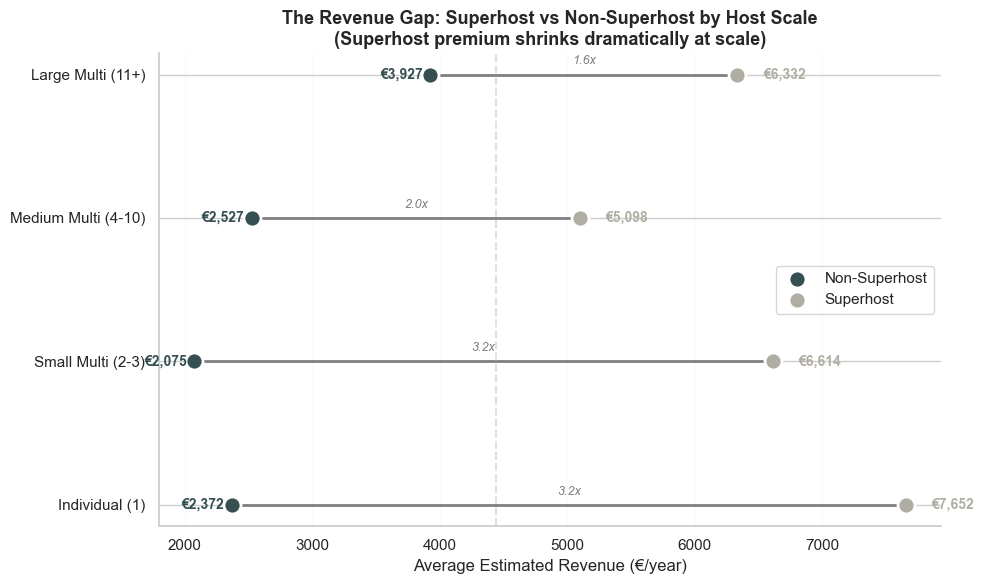

In [84]:
# Dumbbell Plot: Superhost vs Non-Superhost Revenue by Host Category
fig, ax = plt.subplots(figsize=(10, 6))

# Colors
sh_color = '#B0ADA2'      # Superhost
non_sh_color = '#354F52'  # Non-Superhost

# Calculate means for estimated revenue
y_positions = range(len(CATEGORY_ORDER))
sh_means = []
non_sh_means = []

for cat in CATEGORY_ORDER:
    sh = df[(df['host_category'] == cat) & (df['host_is_superhost'] == True)]['estimated_revenue_l365d'].dropna()
    non_sh = df[(df['host_category'] == cat) & (df['host_is_superhost'] == False)]['estimated_revenue_l365d'].dropna()
    sh_means.append(sh.mean())
    non_sh_means.append(non_sh.mean())

# Plot connecting lines (the "dumbbell" bars)
for i, (sh, non_sh) in enumerate(zip(sh_means, non_sh_means)):
    ax.plot([non_sh, sh], [i, i], color='gray', linewidth=2, zorder=1)

# Plot dots
ax.scatter(non_sh_means, y_positions, color=non_sh_color, s=150, zorder=2, label='Non-Superhost', edgecolor='white', linewidth=2)
ax.scatter(sh_means, y_positions, color=sh_color, s=150, zorder=2, label='Superhost', edgecolor='white', linewidth=2)

# Add value labels
for i, (sh, non_sh) in enumerate(zip(sh_means, non_sh_means)):
    ax.text(non_sh - 60, i, f'€{non_sh:,.0f}', ha='right', va='center', fontsize=10, fontweight='bold', color=non_sh_color)
    ax.text(sh + 200, i, f'€{sh:,.0f}', ha='left', va='center', fontsize=10, fontweight='bold', color=sh_color)
    # Add multiplier annotation
    multiplier = sh / non_sh if non_sh > 0 else 0
    mid_point = (sh + non_sh) / 2
    ax.text(mid_point, i + 0.05, f'{multiplier:.1f}x', ha='center', va='bottom', fontsize=9, style='italic', color='gray')

# Styling
ax.set_yticks(y_positions)
ax.set_yticklabels(CATEGORY_ORDER)
ax.set_xlabel('Average Estimated Revenue (€/year)', fontsize=12)
ax.set_title('The Revenue Gap: Superhost vs Non-Superhost by Host Scale\n(Superhost premium shrinks dramatically at scale)', 
             fontsize=13, fontweight='bold')
ax.legend(loc='center right')
ax.axvline(x=df['estimated_revenue_l365d'].mean(), color='lightgray', linestyle='--', alpha=0.7, label='Market Avg')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.1)

plt.tight_layout()
plt.show()

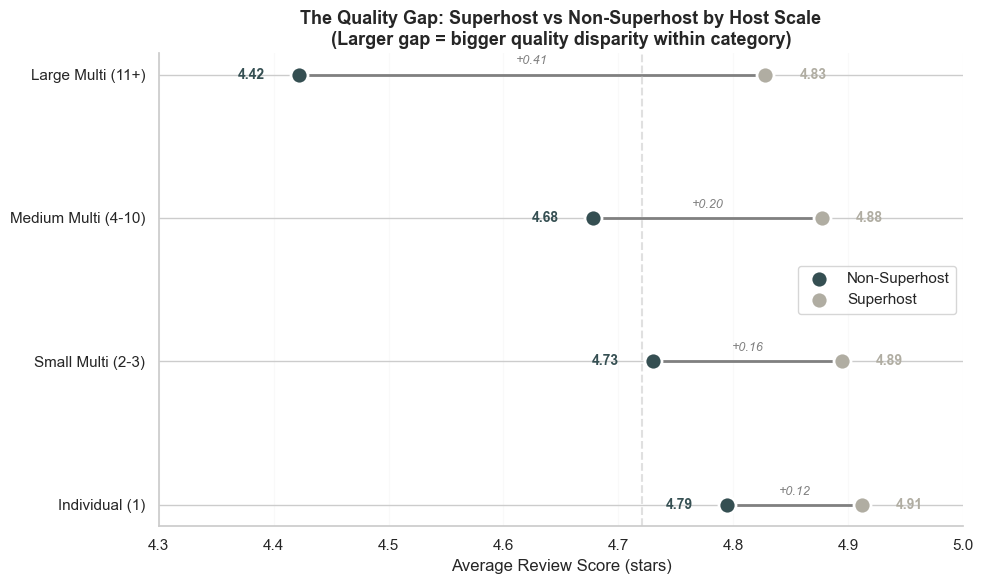

In [85]:
# Dumbbell Plot: Superhost vs Non-Superhost Review Scores by Host Category
fig, ax = plt.subplots(figsize=(10, 6))

# Colors
sh_color = '#B0ADA2'      # Superhost
non_sh_color = '#354F52'  # Non-Superhost

# Calculate means for review scores
y_positions = range(len(CATEGORY_ORDER))
sh_means = []
non_sh_means = []

for cat in CATEGORY_ORDER:
    sh = df[(df['host_category'] == cat) & (df['host_is_superhost'] == True)]['review_scores_rating'].dropna()
    non_sh = df[(df['host_category'] == cat) & (df['host_is_superhost'] == False)]['review_scores_rating'].dropna()
    sh_means.append(sh.mean())
    non_sh_means.append(non_sh.mean())

# Plot connecting lines (the "dumbbell" bars)
for i, (sh, non_sh) in enumerate(zip(sh_means, non_sh_means)):
    ax.plot([non_sh, sh], [i, i], color='gray', linewidth=2, zorder=1)

# Plot dots
ax.scatter(non_sh_means, y_positions, color=non_sh_color, s=150, zorder=2, label='Non-Superhost', edgecolor='white', linewidth=2)
ax.scatter(sh_means, y_positions, color=sh_color, s=150, zorder=2, label='Superhost', edgecolor='white', linewidth=2)

# Add value labels
for i, (sh, non_sh) in enumerate(zip(sh_means, non_sh_means)):
    ax.text(non_sh - 0.03, i, f'{non_sh:.2f}', ha='right', va='center', fontsize=10, fontweight='bold', color=non_sh_color)
    ax.text(sh + 0.03, i, f'{sh:.2f}', ha='left', va='center', fontsize=10, fontweight='bold', color=sh_color)
    # Add gap annotation
    gap = sh - non_sh
    mid_point = (sh + non_sh) / 2
    ax.text(mid_point, i + 0.05, f'+{gap:.2f}', ha='center', va='bottom', fontsize=9, style='italic', color='gray')

# Styling
ax.set_yticks(y_positions)
ax.set_yticklabels(CATEGORY_ORDER)
ax.set_xlabel('Average Review Score (stars)', fontsize=12)
ax.set_title('The Quality Gap: Superhost vs Non-Superhost by Host Scale\n(Larger gap = bigger quality disparity within category)', 
             fontsize=13, fontweight='bold')
ax.set_xlim(4.3, 5.0)
ax.legend(loc='center right')
ax.axvline(x=df['review_scores_rating'].mean(), color='lightgray', linestyle='--', alpha=0.7, label='Market Avg')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.1)

plt.tight_layout()
plt.show()

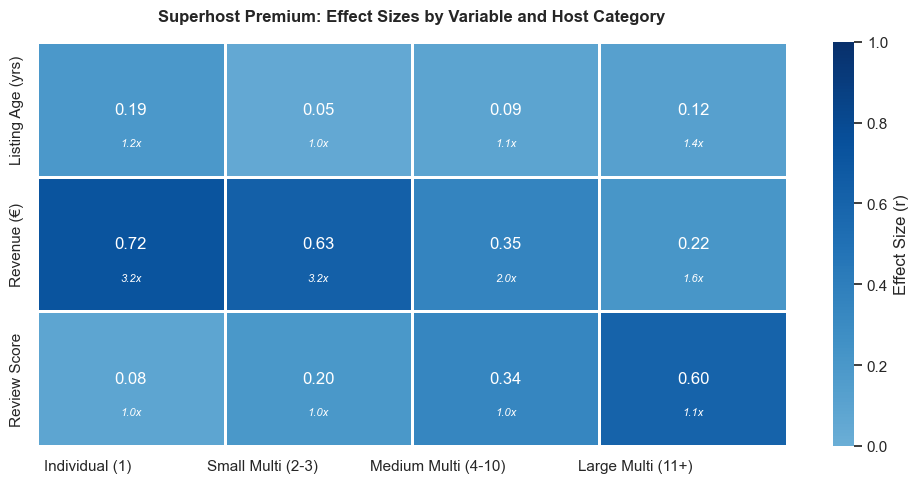

In [86]:
# Heatmap: Effect Sizes for Superhost Premium by Variable and Host Category
fig, ax = plt.subplots(figsize=(10, 5))

# Prepare data for heatmap from the summary_table
heatmap_data = np.abs(summary_table.pivot(index='Variable', columns='Category', values='Effect Size (r)'))
heatmap_data = heatmap_data[CATEGORY_ORDER]  # Ensure correct order

# Create heatmap with diverging colormap (centered at 0)
# Positive r = Superhost > Non-Superhost
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='Blues', center=0,
            linewidths=2, linecolor='white', cbar_kws={'label': 'Effect Size (r)'},
            ax=ax, vmin=0, vmax=1)

# Add ratio annotations below effect sizes
for i, var in enumerate(heatmap_data.index):
    for j, cat in enumerate(heatmap_data.columns):
        ratio = summary_table[(summary_table['Variable'] == var) & 
                              (summary_table['Category'] == cat)]['Ratio (SH/Non-SH)'].values
        if len(ratio) > 0:
            ax.text(j + 0.5, i + 0.75, f'{ratio[0]:.1f}x', ha='center', va='center', 
                    fontsize=8, color='white', style='italic')

ax.set_title('Superhost Premium: Effect Sizes by Variable and Host Category', 
             fontsize=12, fontweight='bold', pad=15)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')

plt.tight_layout()
plt.show()

In [87]:
# Calculate market share of non-superhost Large Multi hosts
large_multi_non_sh = df[(df['host_category'] == 'Large Multi (11+)') & (df['host_is_superhost'] == False)]
large_multi_non_sh_na = df[(df['host_category'] == 'Large Multi (11+)') & (df['host_is_superhost'].isna())]
large_multi_non_sh_share = (len(large_multi_non_sh) / total_listings) * 100
large_multi_non_sh_share_na = ((len(large_multi_non_sh_na) + len(large_multi_non_sh))/ total_listings) * 100


print(f"\nNon-Superhost Large Multi listings: about {large_multi_non_sh_share:.1f}% - {large_multi_non_sh_share_na:.1f}% of market)")


Non-Superhost Large Multi listings: about 22.0% - 27.9% of market)


#### **Main Findings**

* Superhost status is a massive revenue differentiator for smaller operators (especially Individual and Small Multi hosts - 3.23x and 3.19x respectively).
* Large Multi non-superhosts is the group with the youngest listings (2.1 years old average), indicating a dynamic where large operators prioritize portfolio expansion.
* Large Multi non-superhosts average ratings are significantly lower (4.42★) than other groups, suggesting a quantity-over-quality approach.

#### **Comment:** 

Large multi-listing operators (11+ properties) represent Thessaloniki's newest market entrants (median 1.6 years vs. 2.4 years for individuals), suggesting a recent wave of commercial investment in the STR sector. However, this rapid scaling has come at a measurable cost to guest experience.  

Specifically, non-superhost large operators - representing ~25% of the market — deliver the worst guest experience (4.42★), a full 0.3 stars below the overall average. Yet those operators appear to tolerate lower ratings, likely because their business model prioritizes volume over premium services. Or even because quality investment is less rewarded at scale — perhaps guests already expect professionalism from commercial operators. This is backed up by data: superhost status yields only a 1.7x revenue multiplier for large operators, compared to over 3x for smaller hosts. 

Things are different for individual and small multi-property hosts. Quality is not merely a differentiator — it's a survival strategy. The superhost badge serves as a critical lever for revenue growth, enabling smaller operators to compete against commercial scale through reputation and guest loyalty.

<hr>

### **Summary and Recommendations**

Our analysis suggests that Thessaloniki's STR market performs optimally in the small-to-medium host segment (2-10 listings). These operators achieve:

* The highest superhost rates (45-47%)
* Strong revenue performance
* Quality scores comparable to individual hosts

On the other hand, large commercial operators (11+ listings), while contributing to market supply, show evidence of a "volume over quality" approach that may undermine destination reputation. Their youngest listings, lowest superhost rates, and significantly lower non-superhost review scores (4.42★) suggest rapid, quality-agnostic expansion.

For policymakers, the message is clear: Host diversity matters. Policies that encourage mid-scale professionalization while maintaining quality standards will better serve Thessaloniki's tourism ecosystem than unchecked commercial consolidation.

<hr>

## Appendix: Exploratory Analysis Code

*The cells below contain exploratory analysis used during development. They are preserved for reproducibility but are not part of the main narrative.*

In [88]:
# Variables to check against host category
variables = [
    "listing_age_years",
    "estimated_revenue_l365d",
    "estimated_occupancy_l365d",
    "review_scores_rating",
    "host_is_superhost",
    "host_acceptance_rate",
    "price_cat"
]

DESCRIPTIVE STATISTICS: listing_age_years

Central Tendency:
  Mean:           2.78
  Median:         1.89
  Mode:           0.6543463381245722

Dispersion:
  Std Dev:        2.51
  Variance:       6.31
  Range:          13.06
  IQR:            3.18

Quartiles:
  Min (0%):       0.00
  Q1 (25%):       0.82
  Q2 (50%):       1.89
  Q3 (75%):       4.00
  Max (100%):     13.06

Shape:
  Skewness:       1.070
  Kurtosis:       0.223

Sample Size:
  Valid:          4124
  Missing:        0
  Total:          4124


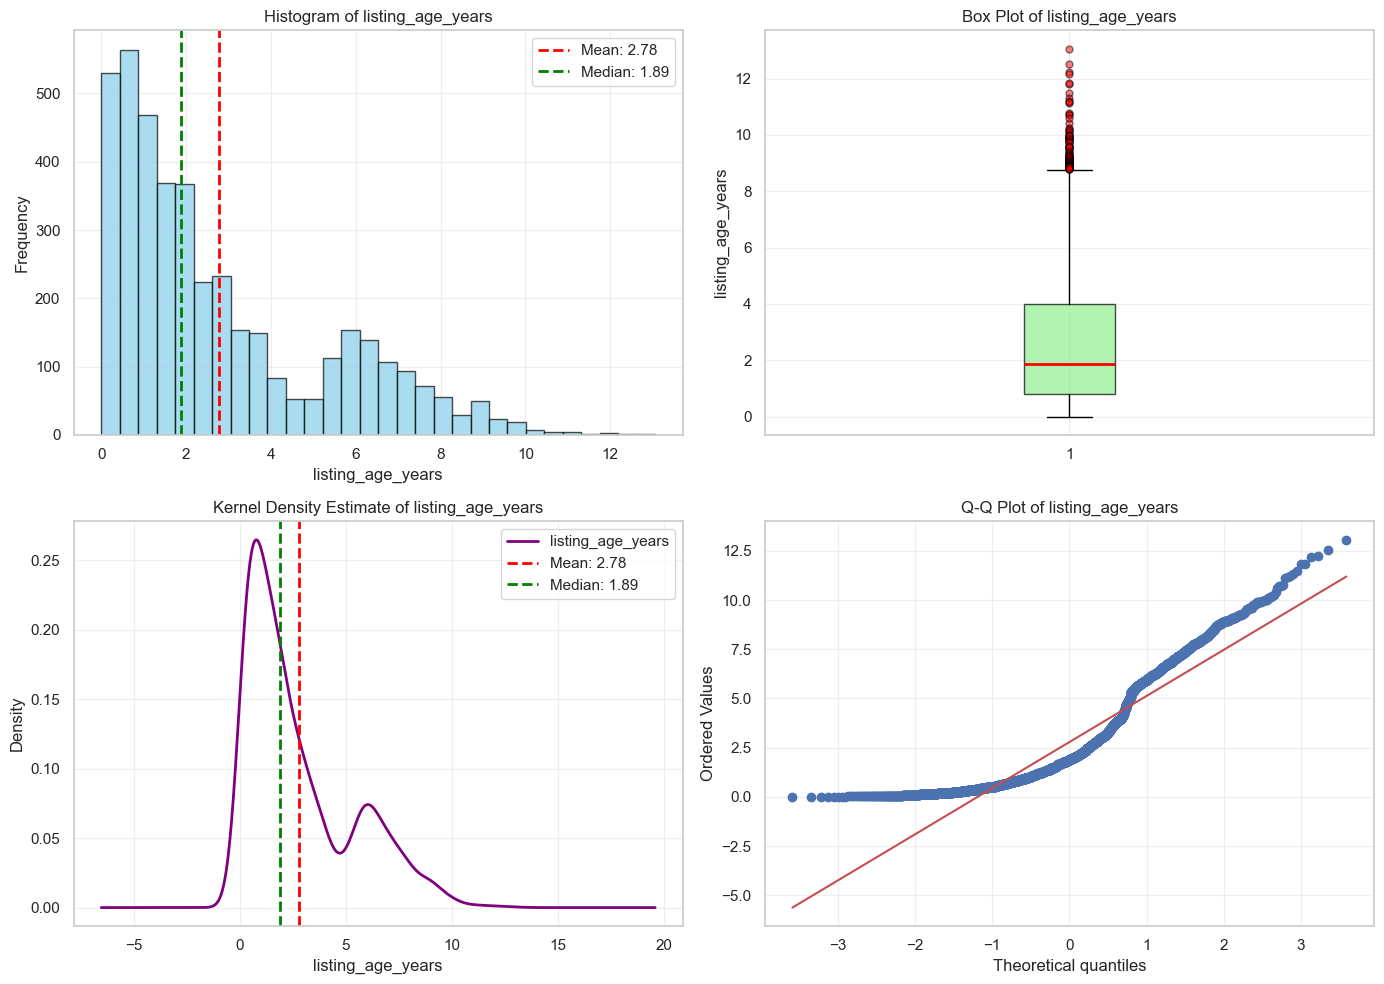

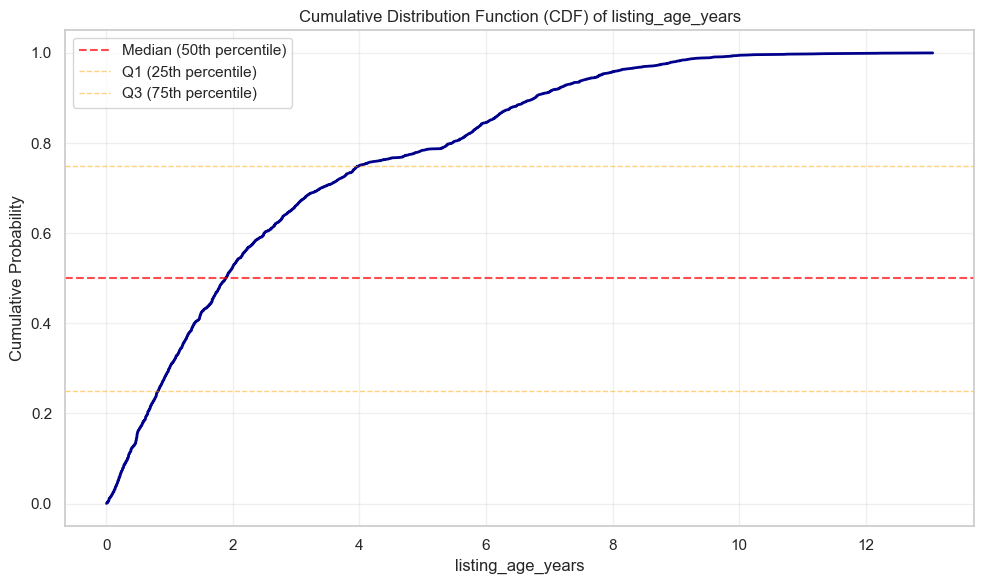

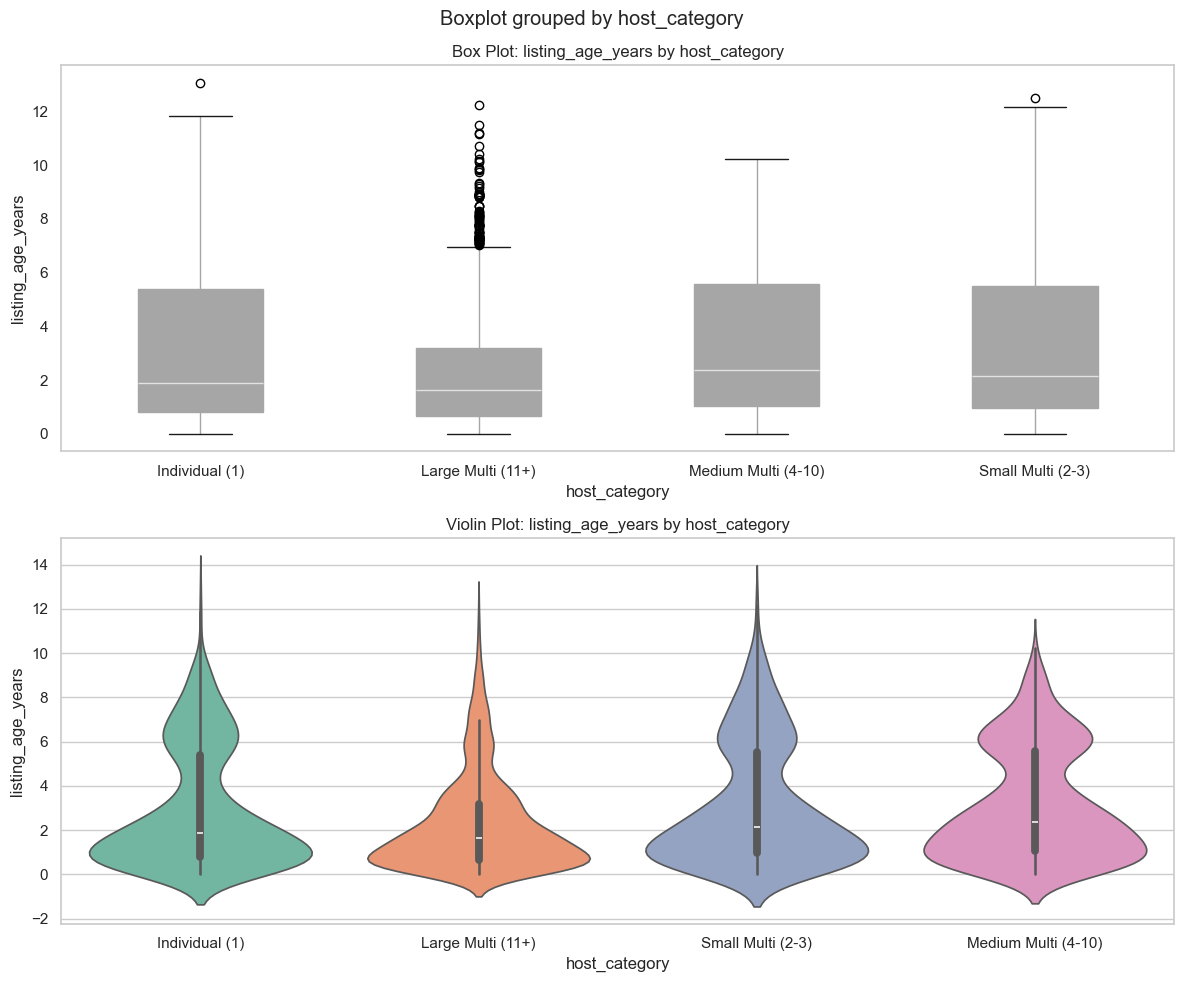

ONE-WAY ANOVA: listing_age_years by host_category

Descriptive Statistics by Group:

  host_category = Individual (1):
    N:      1003
    Mean:   2.9731
    Median: 1.8864
    Std:    2.6991
    Min:    0.0027
    Max:    13.0595

  host_category = Large Multi (11+):
    N:      1576
    Mean:   2.2963
    Median: 1.6372
    Std:    2.1744
    Min:    0.0055
    Max:    12.2409

  host_category = Small Multi (2-3):
    N:      765
    Mean:   3.1555
    Median: 2.1492
    Std:    2.7498
    Min:    0.0110
    Max:    12.5175

  host_category = Medium Multi (4-10):
    N:      780
    Mean:   3.1556
    Median: 2.3819
    Std:    2.5049
    Min:    0.0164
    Max:    10.2204

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      33.7229
  P-value:             0.000000
  Eta-squared (η²):    0.024
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). host_category has a significant effect

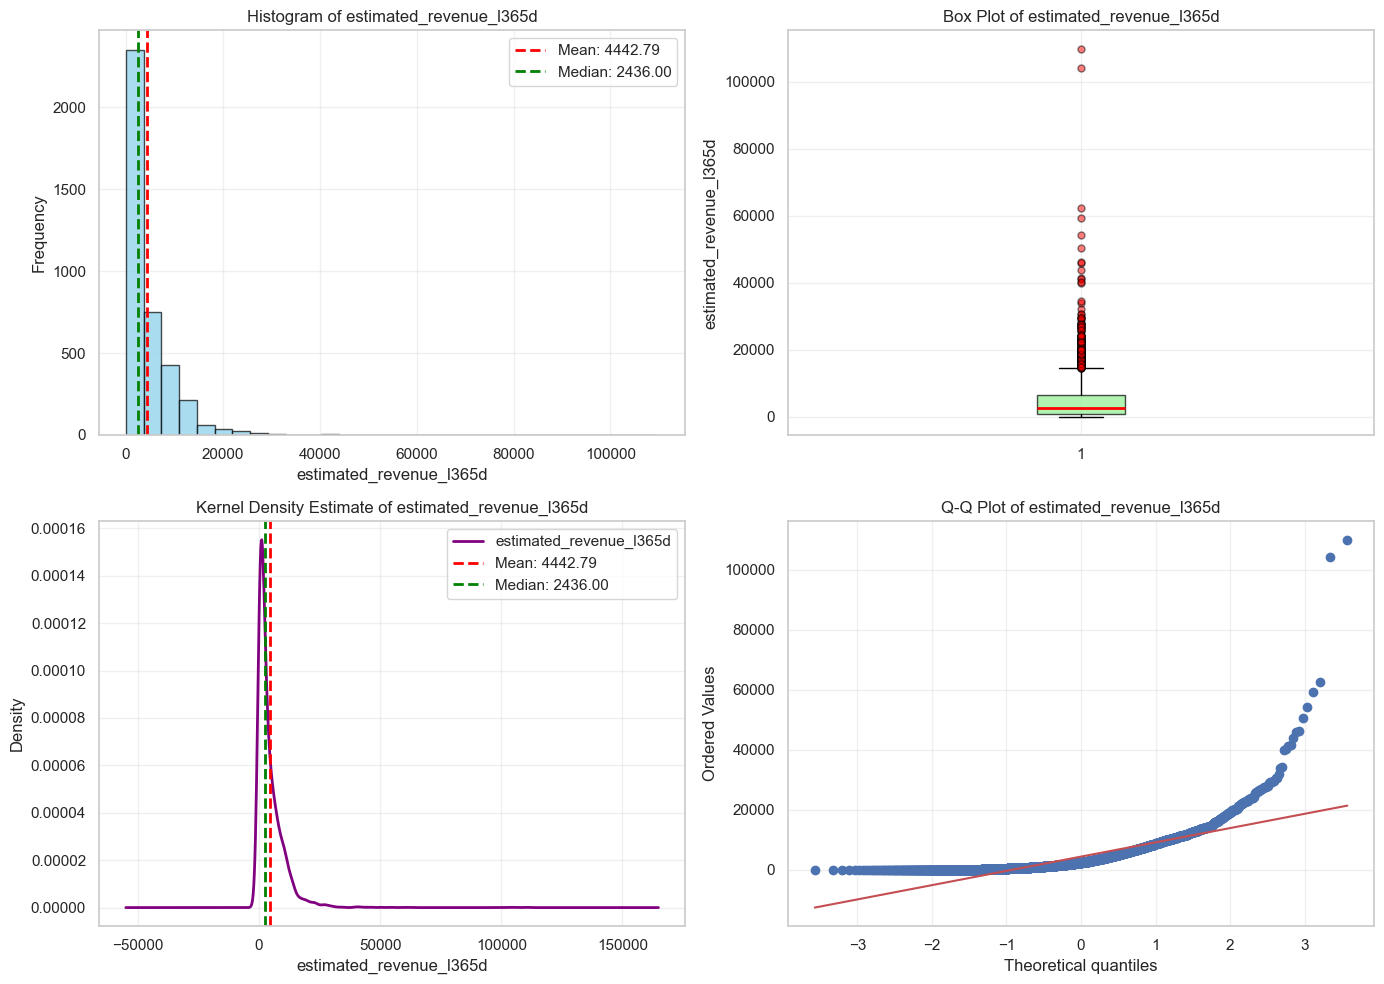

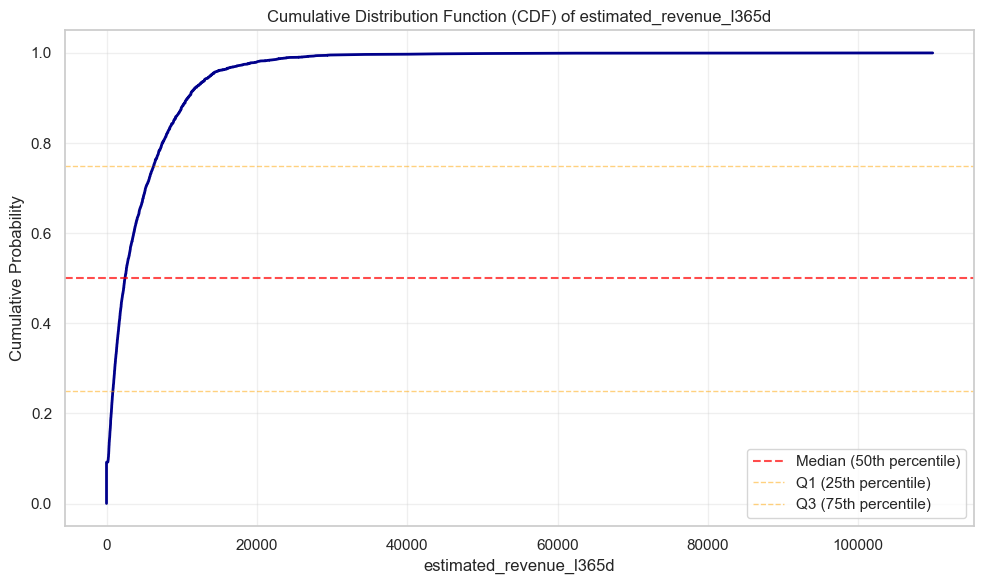

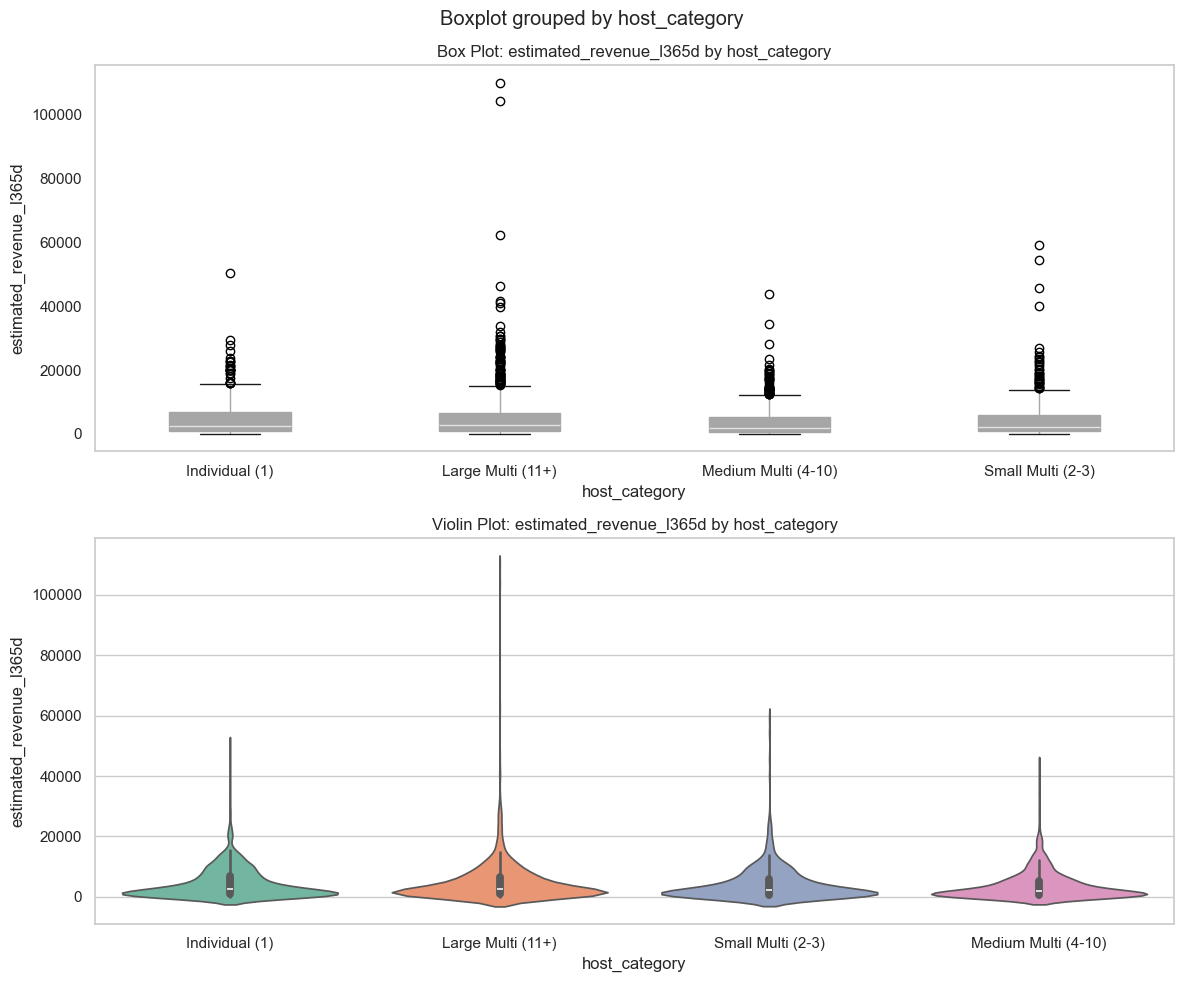

ONE-WAY ANOVA: estimated_revenue_l365d by host_category

Descriptive Statistics by Group:

  host_category = Individual (1):
    N:      946
    Mean:   4437.3446
    Median: 2592.0000
    Std:    4954.4437
    Min:    0.0000
    Max:    50430.0000

  host_category = Large Multi (11+):
    N:      1497
    Mean:   4860.6520
    Median: 2688.0000
    Std:    6848.4133
    Min:    0.0000
    Max:    109896.0000

  host_category = Small Multi (2-3):
    N:      727
    Mean:   4271.9739
    Median: 2220.0000
    Std:    5767.1019
    Min:    0.0000
    Max:    59280.0000

  host_category = Medium Multi (4-10):
    N:      737
    Mean:   3769.5156
    Median: 1980.0000
    Std:    4675.1146
    Min:    0.0000
    Max:    43836.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      6.0059
  P-value:             0.000444
  Eta-squared (η²):    0.005
  Effect size:         Negligible effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference det

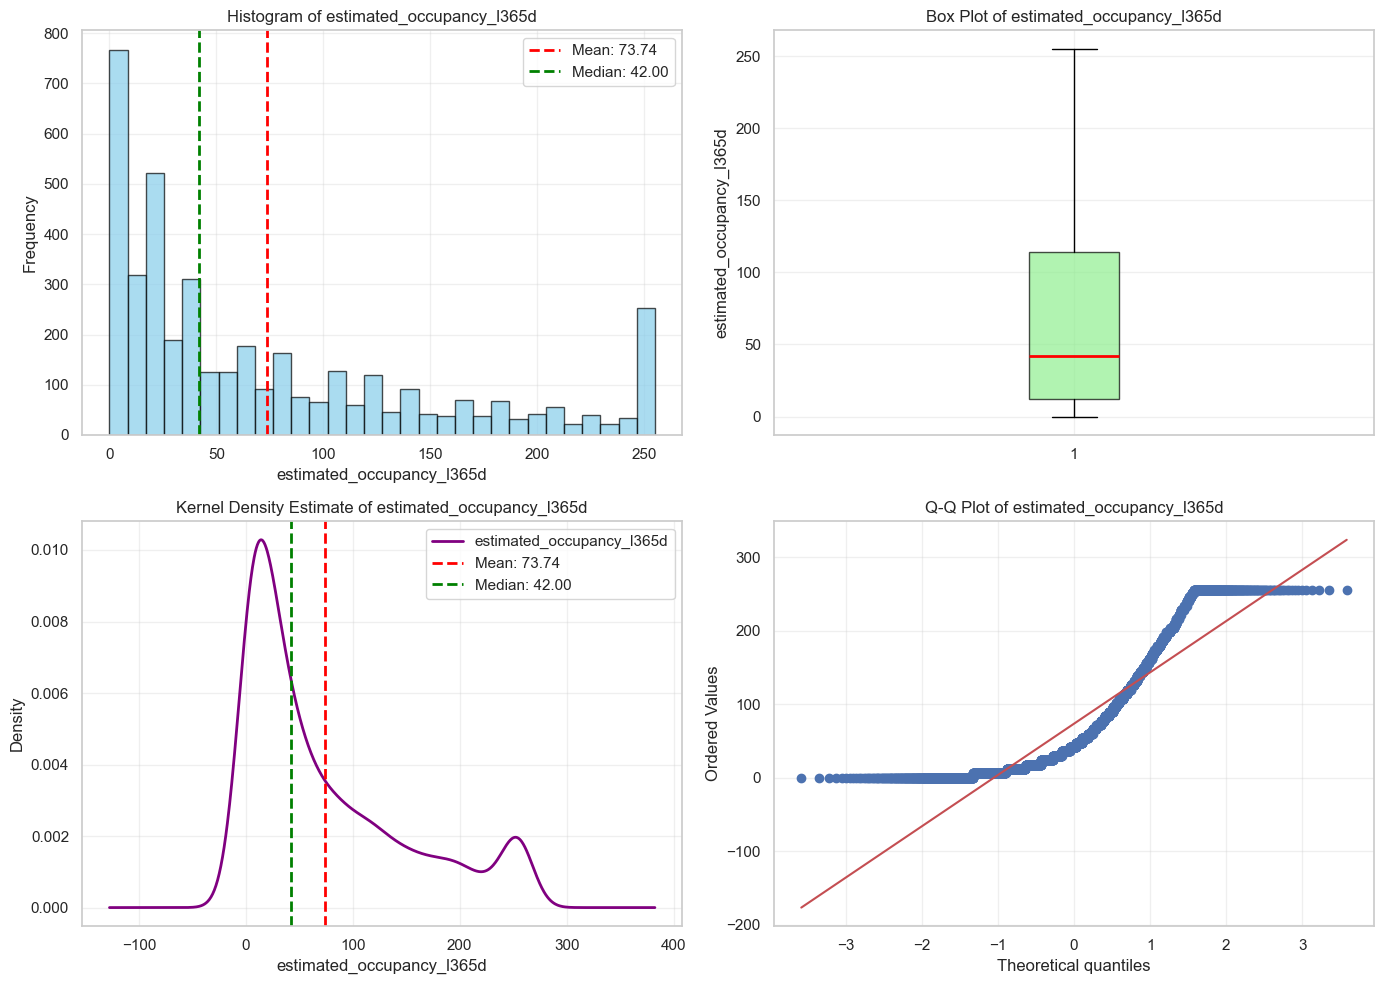

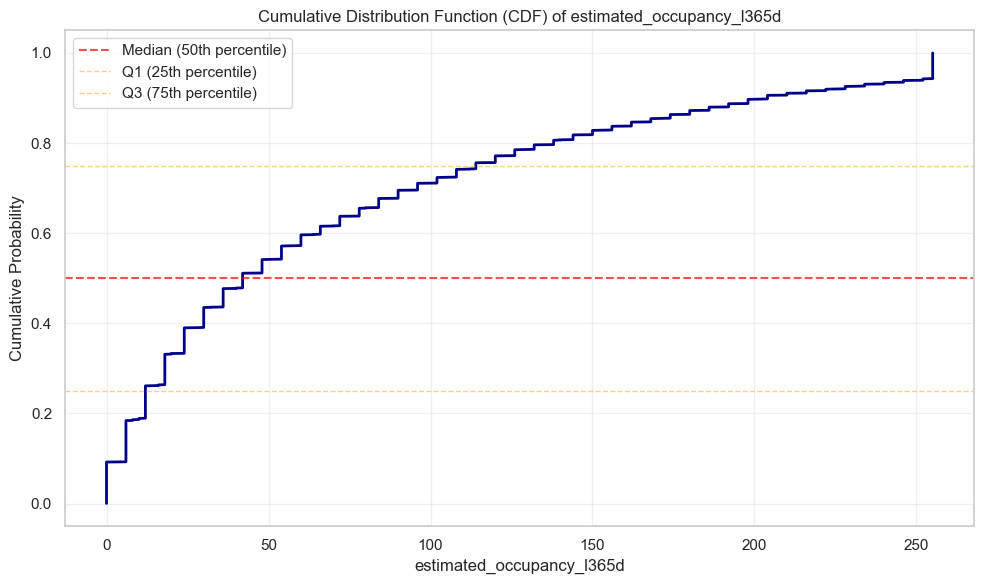

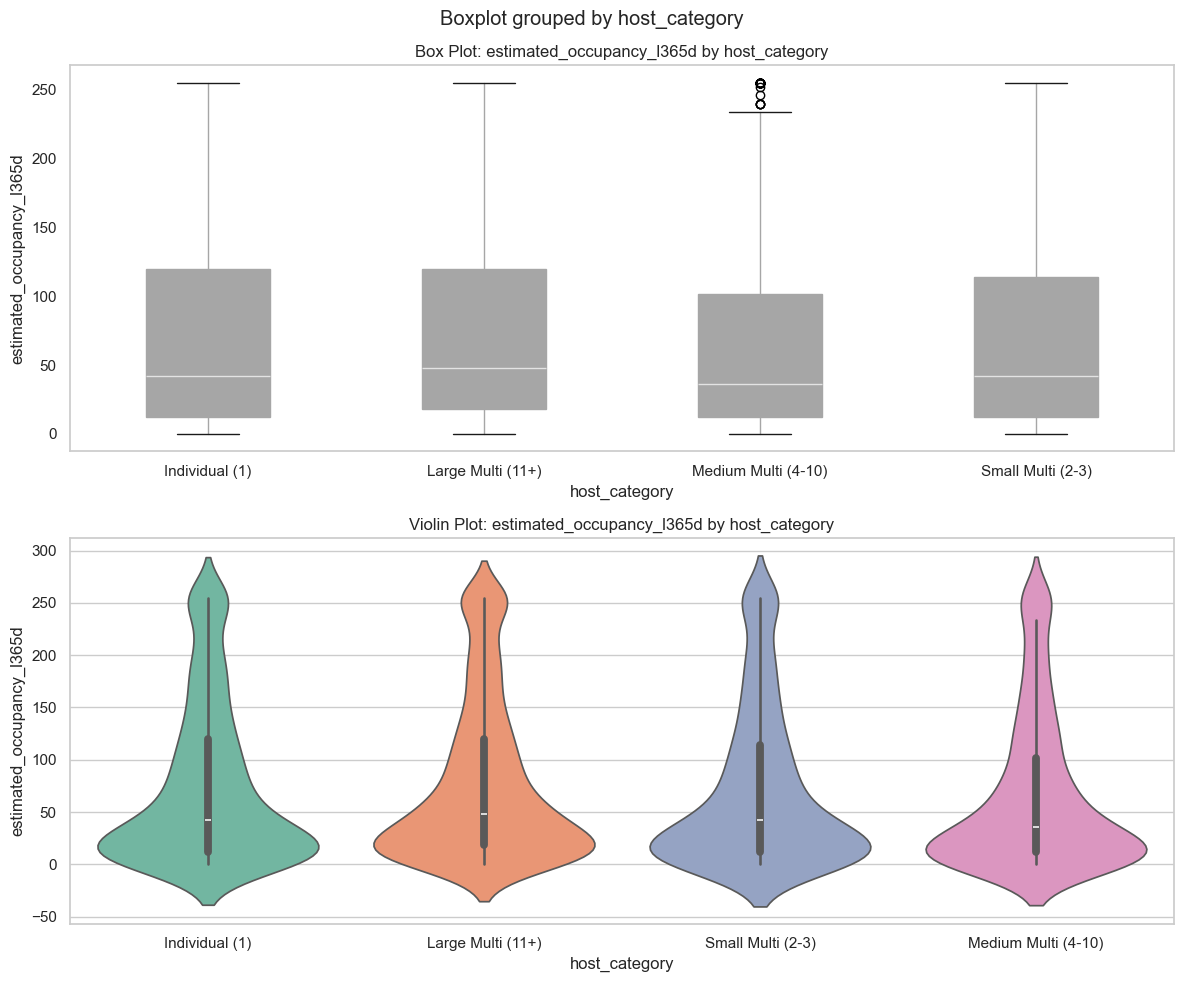

ONE-WAY ANOVA: estimated_occupancy_l365d by host_category

Descriptive Statistics by Group:

  host_category = Individual (1):
    N:      1003
    Mean:   75.1446
    Median: 42.0000
    Std:    76.9918
    Min:    0.0000
    Max:    255.0000

  host_category = Large Multi (11+):
    N:      1576
    Mean:   77.7843
    Median: 48.0000
    Std:    76.8784
    Min:    0.0000
    Max:    255.0000

  host_category = Small Multi (2-3):
    N:      765
    Mean:   71.2497
    Median: 42.0000
    Std:    75.9631
    Min:    0.0000
    Max:    255.0000

  host_category = Medium Multi (4-10):
    N:      780
    Mean:   66.2269
    Median: 36.0000
    Std:    73.9904
    Min:    0.0000
    Max:    255.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      4.3935
  P-value:             0.004301
  Eta-squared (η²):    0.003
  Effect size:         Negligible effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.004301). host_categ

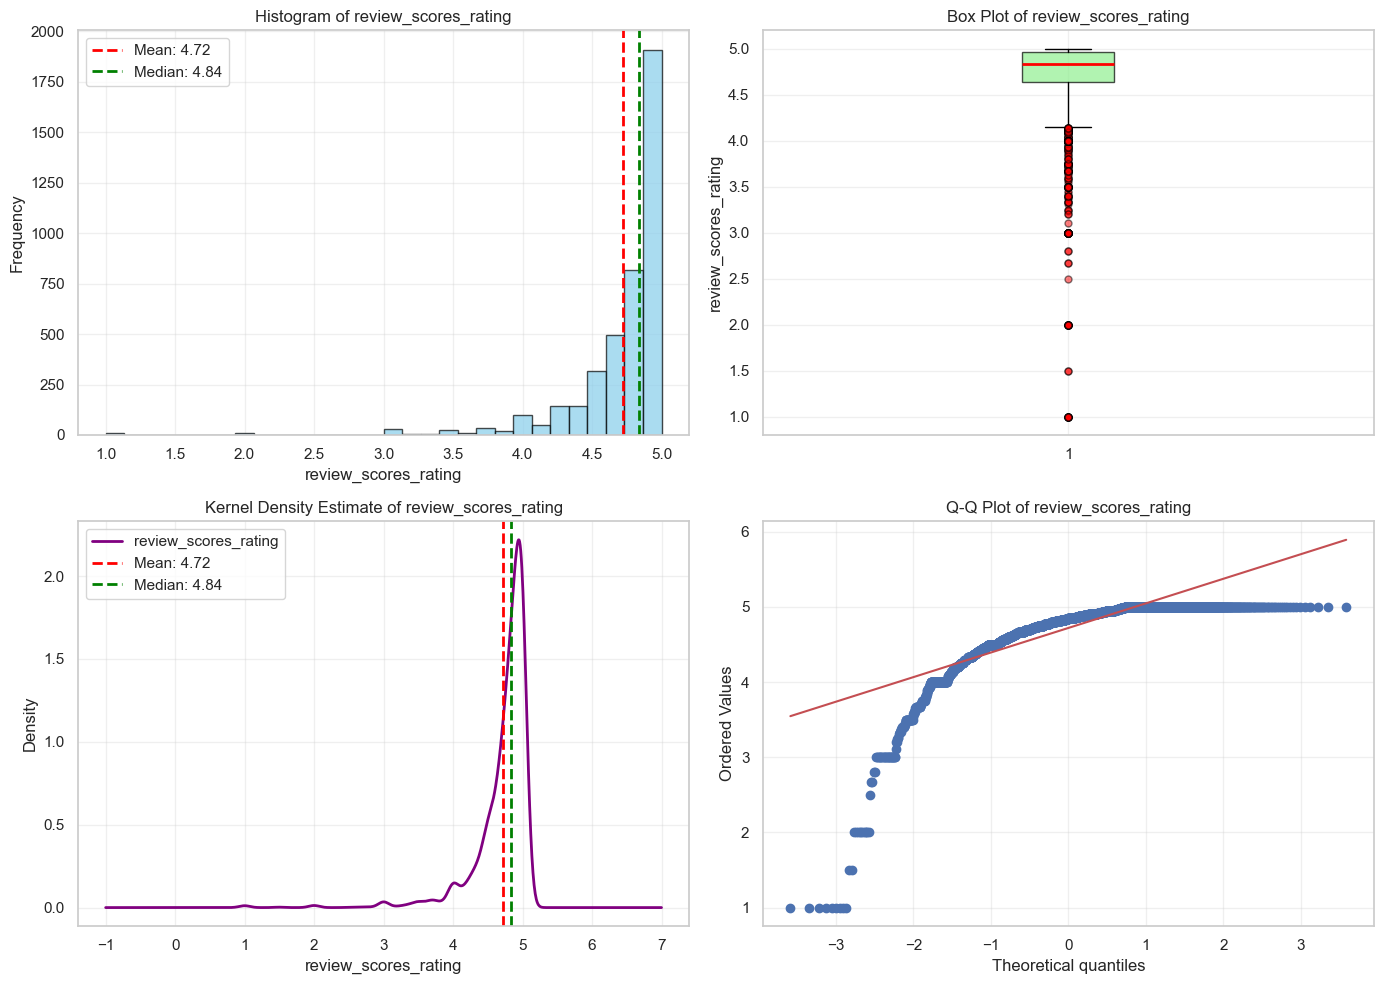

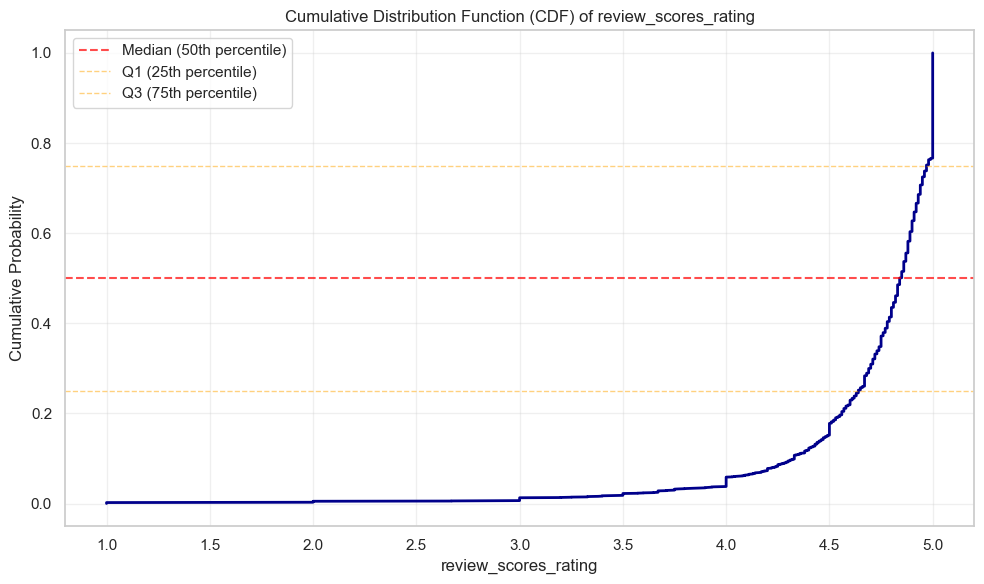

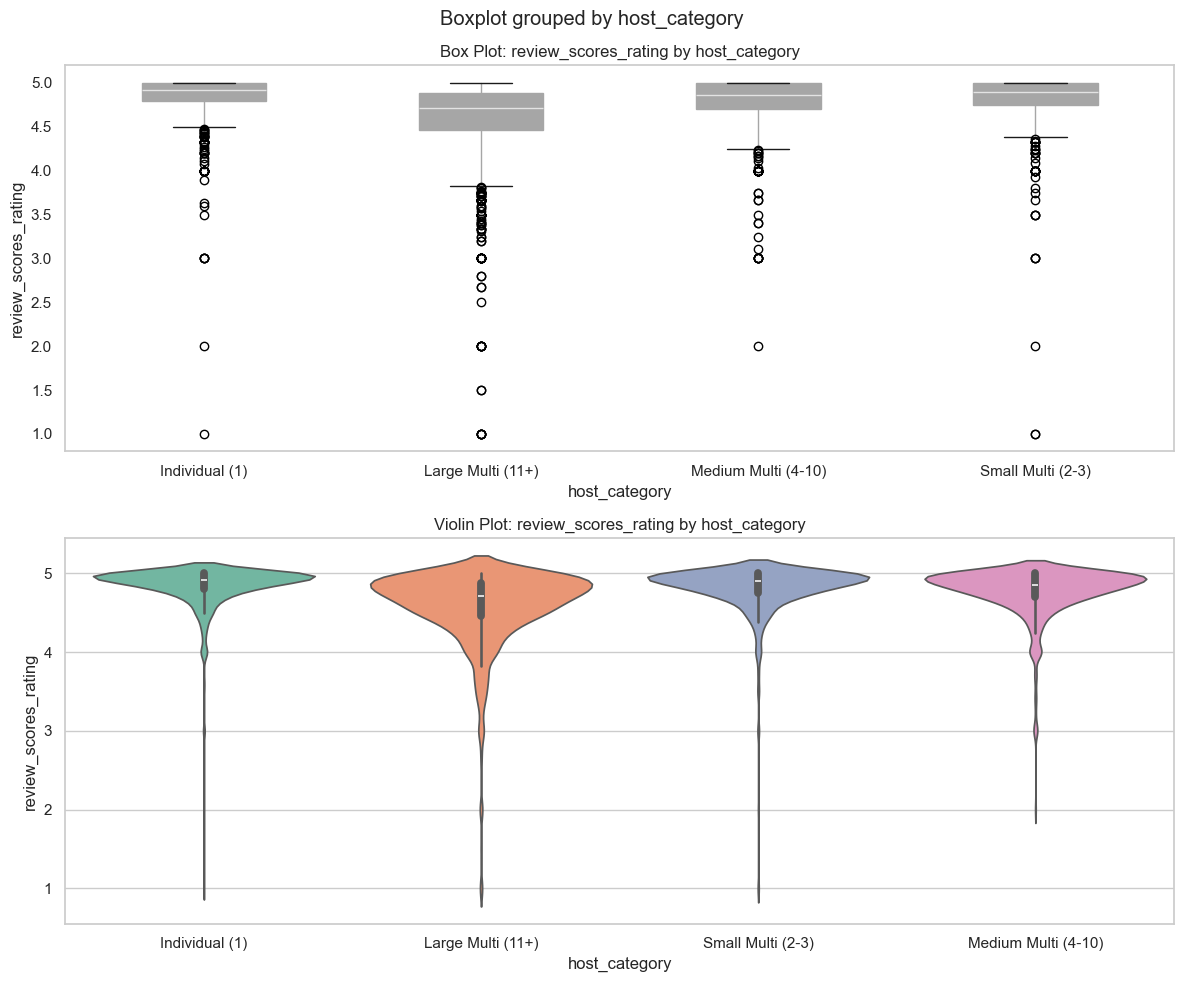

ONE-WAY ANOVA: review_scores_rating by host_category

Descriptive Statistics by Group:

  host_category = Individual (1):
    N:      1003
    Mean:   4.8399
    Median: 4.9200
    Std:    0.2808
    Min:    1.0000
    Max:    5.0000

  host_category = Large Multi (11+):
    N:      1576
    Mean:   4.5767
    Median: 4.7100
    Std:    0.4993
    Min:    1.0000
    Max:    5.0000

  host_category = Small Multi (2-3):
    N:      765
    Mean:   4.8081
    Median: 4.9000
    Std:    0.3340
    Min:    1.0000
    Max:    5.0000

  host_category = Medium Multi (4-10):
    N:      780
    Mean:   4.7721
    Median: 4.8600
    Std:    0.3187
    Min:    2.0000
    Max:    5.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      118.3670
  P-value:             0.000000
  Eta-squared (η²):    0.079
  Effect size:         Medium effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). host_category has a significant effec

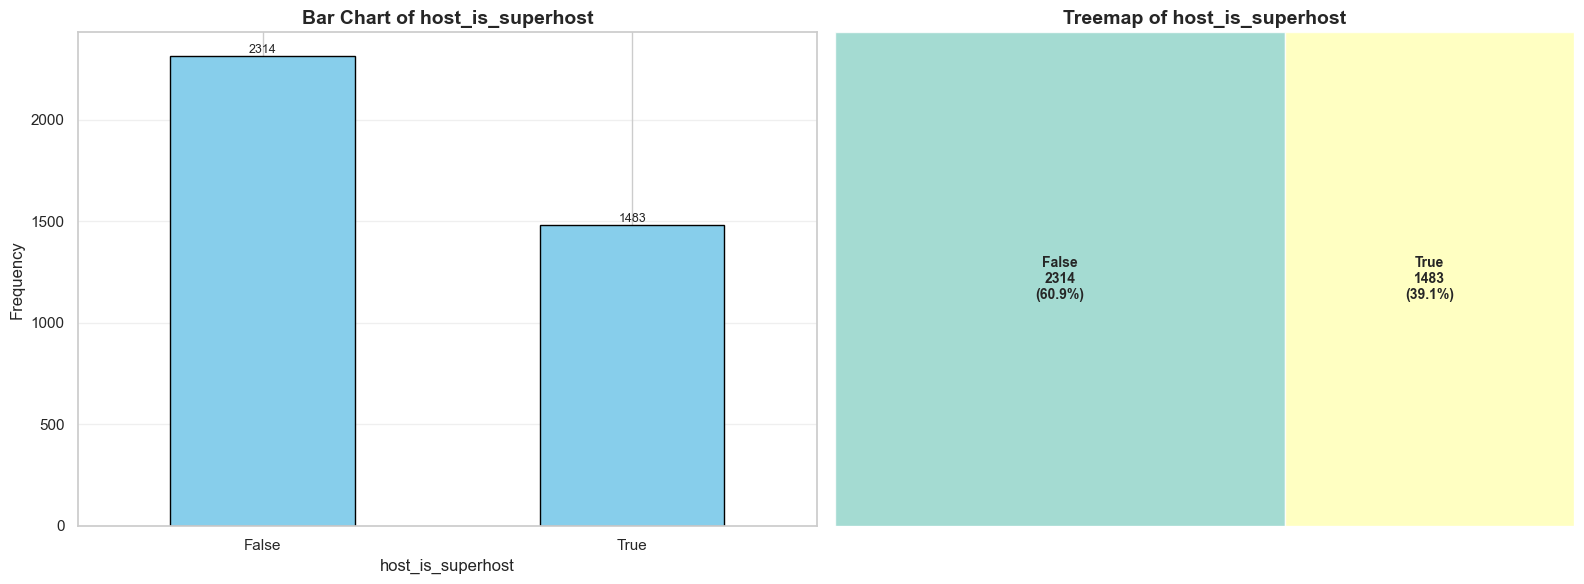

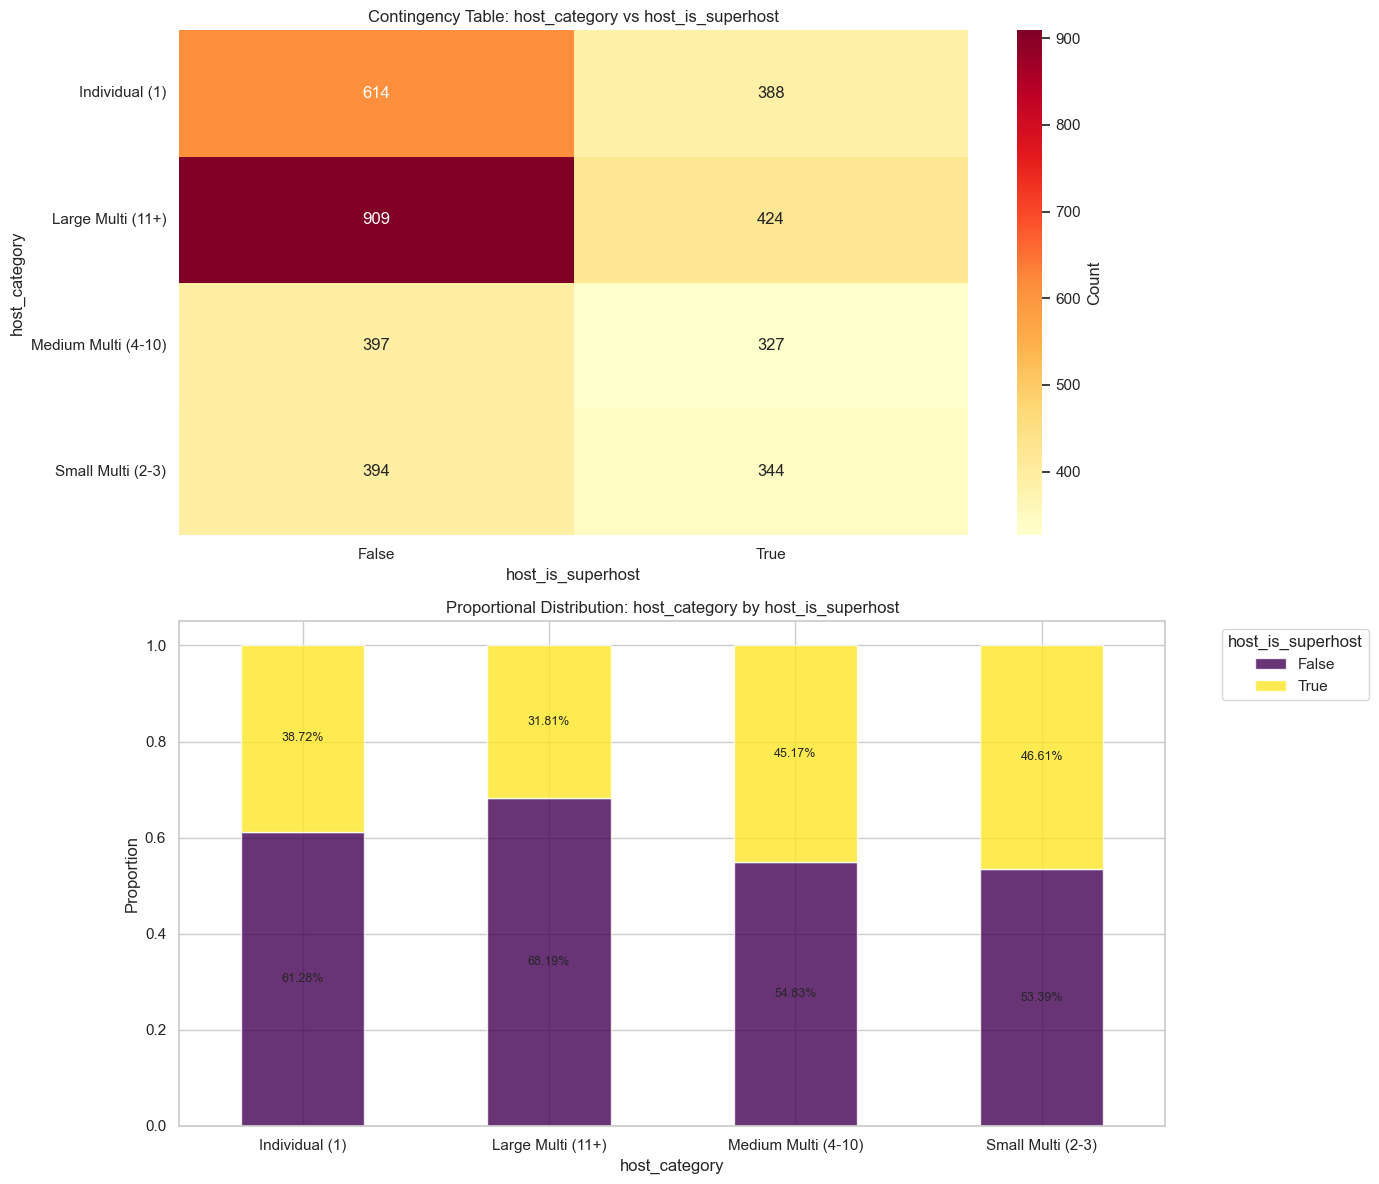

CHI-SQUARE TEST OF INDEPENDENCE: host_category vs host_is_superhost

Contingency Table:
host_is_superhost    False  True 
host_category                    
Individual (1)         614    388
Large Multi (11+)      909    424
Medium Multi (4-10)    397    327
Small Multi (2-3)      394    344

Test Statistics:
  Chi-square statistic: 58.5255
  Degrees of freedom:   3
  P-value:              0.000000
  Cramér's V:           0.124
  Effect size:          Weak association
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT association detected (p=0.000000). host_category and host_is_superhost are related. Weak association (Cramér's V = 0.124).

 

DESCRIPTIVE STATISTICS: host_acceptance_rate

Central Tendency:
  Mean:           0.95
  Median:         1.00
  Mode:           1.0

Dispersion:
  Std Dev:        0.16
  Variance:       0.02
  Range:          1.00
  IQR:            0.01

Quartiles:
  Min (0%):       0.00
  Q1 (25%):       0.99
  Q2 (50%):       1.00
  Q3 (75%):       1.00


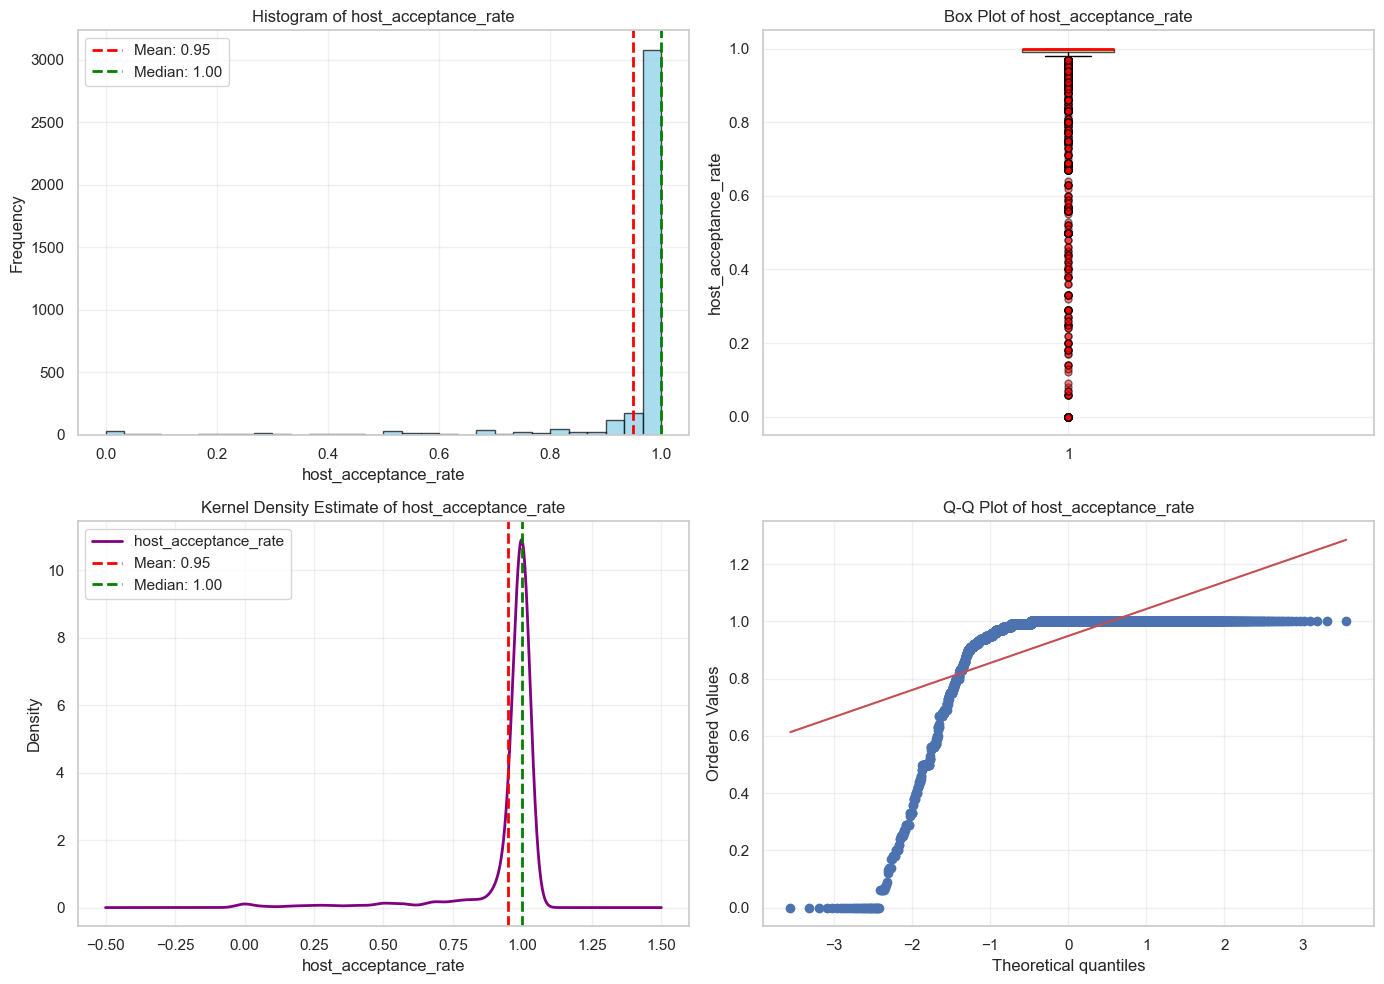

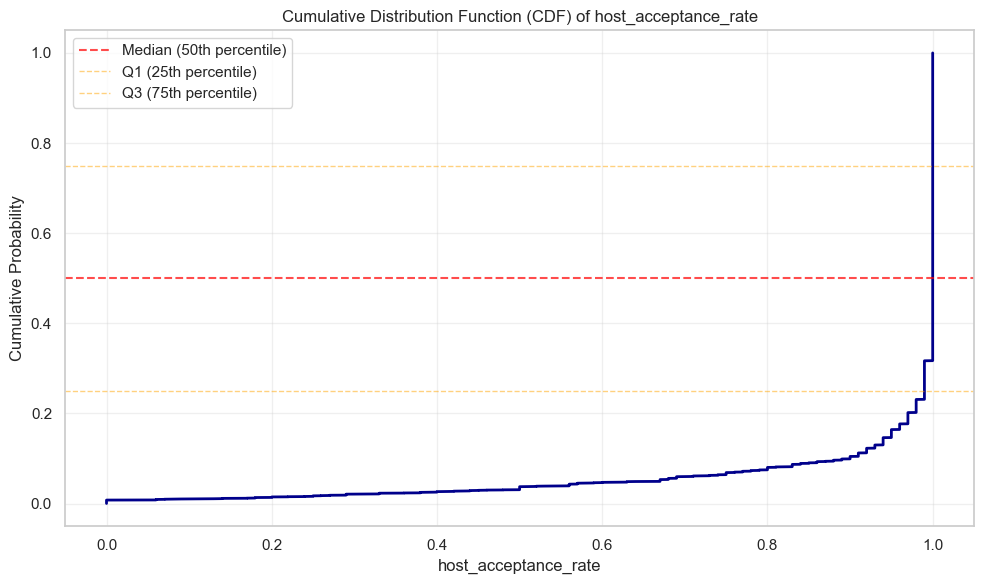

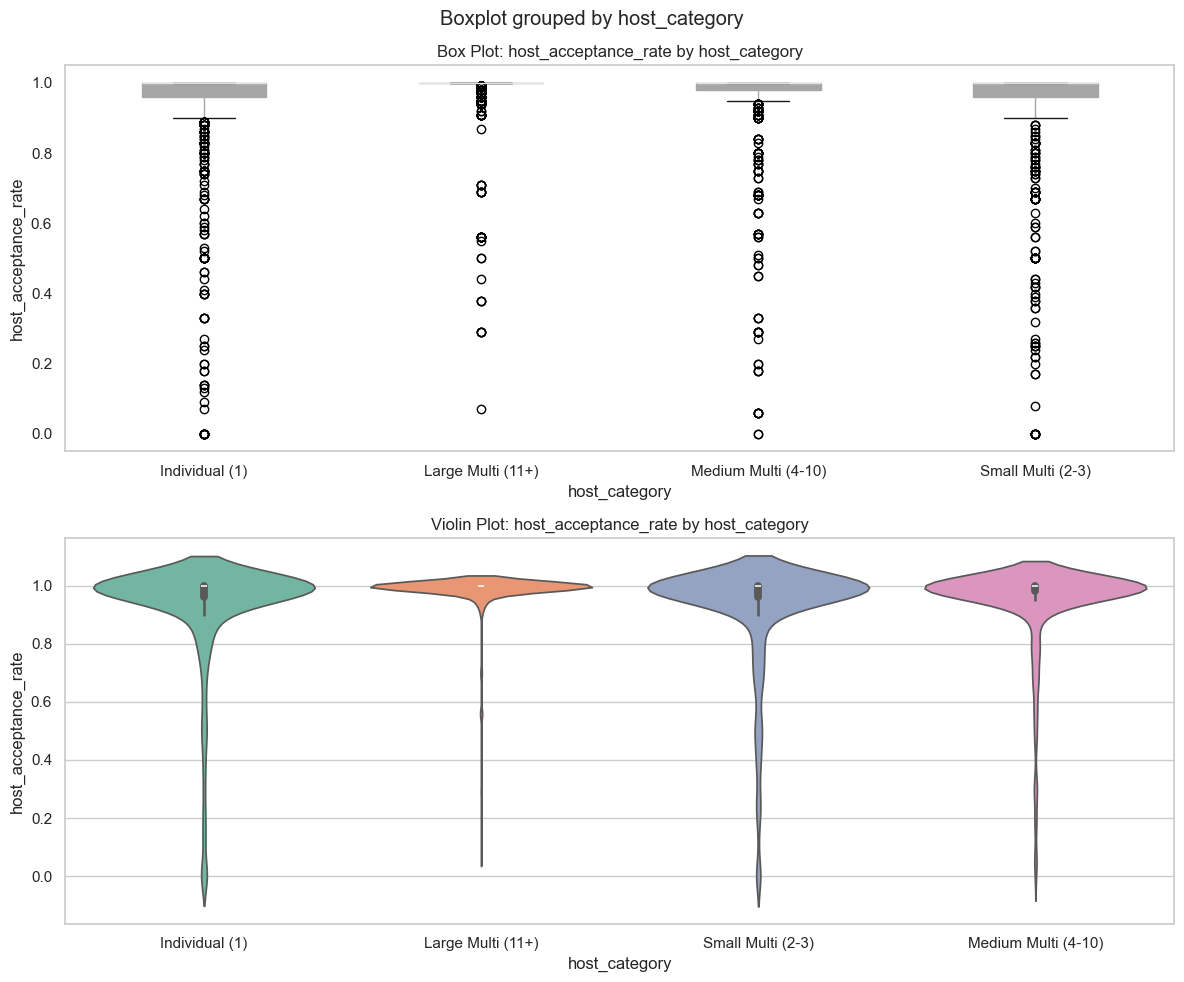

ONE-WAY ANOVA: host_acceptance_rate by host_category

Descriptive Statistics by Group:

  host_category = Individual (1):
    N:      884
    Mean:   0.9230
    Median: 1.0000
    Std:    0.1980
    Min:    0.0000
    Max:    1.0000

  host_category = Large Multi (11+):
    N:      1414
    Mean:   0.9839
    Median: 1.0000
    Std:    0.0751
    Min:    0.0700
    Max:    1.0000

  host_category = Small Multi (2-3):
    N:      708
    Mean:   0.9200
    Median: 1.0000
    Std:    0.1932
    Min:    0.0000
    Max:    1.0000

  host_category = Medium Multi (4-10):
    N:      734
    Mean:   0.9429
    Median: 1.0000
    Std:    0.1584
    Min:    0.0000
    Max:    1.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      41.9766
  P-value:             0.000000
  Eta-squared (η²):    0.033
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). host_category has a significant effect o

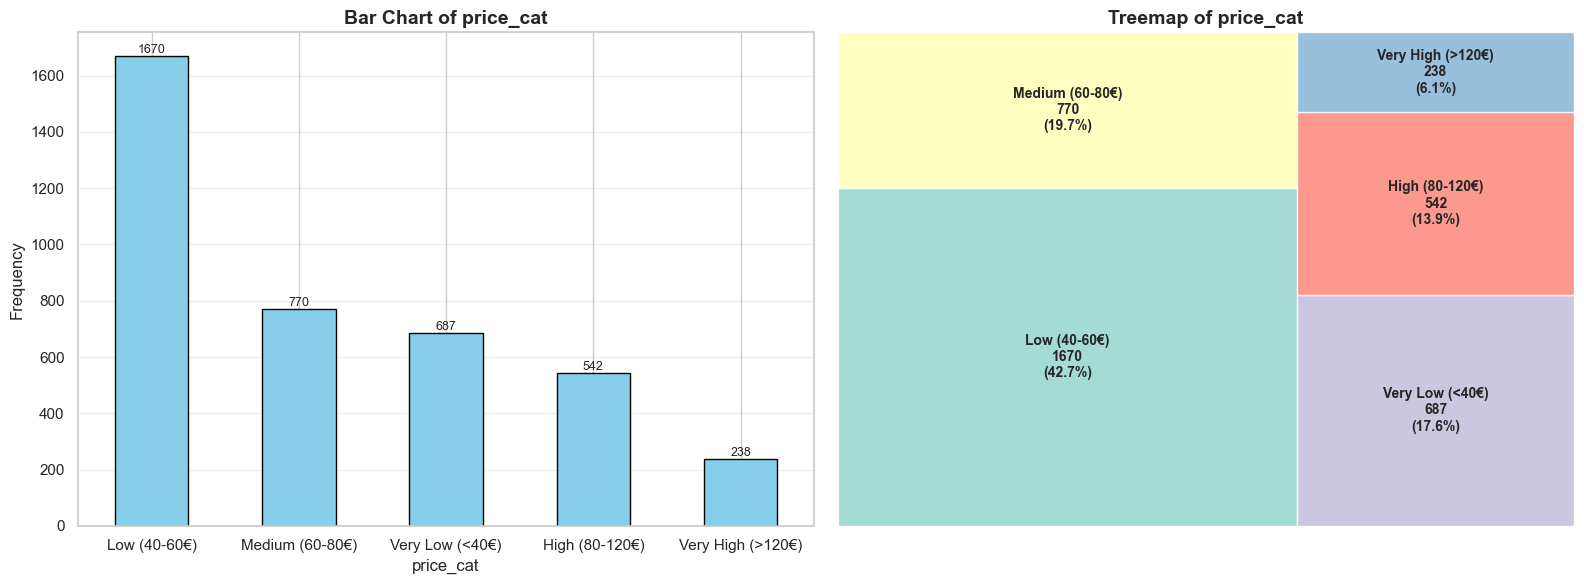

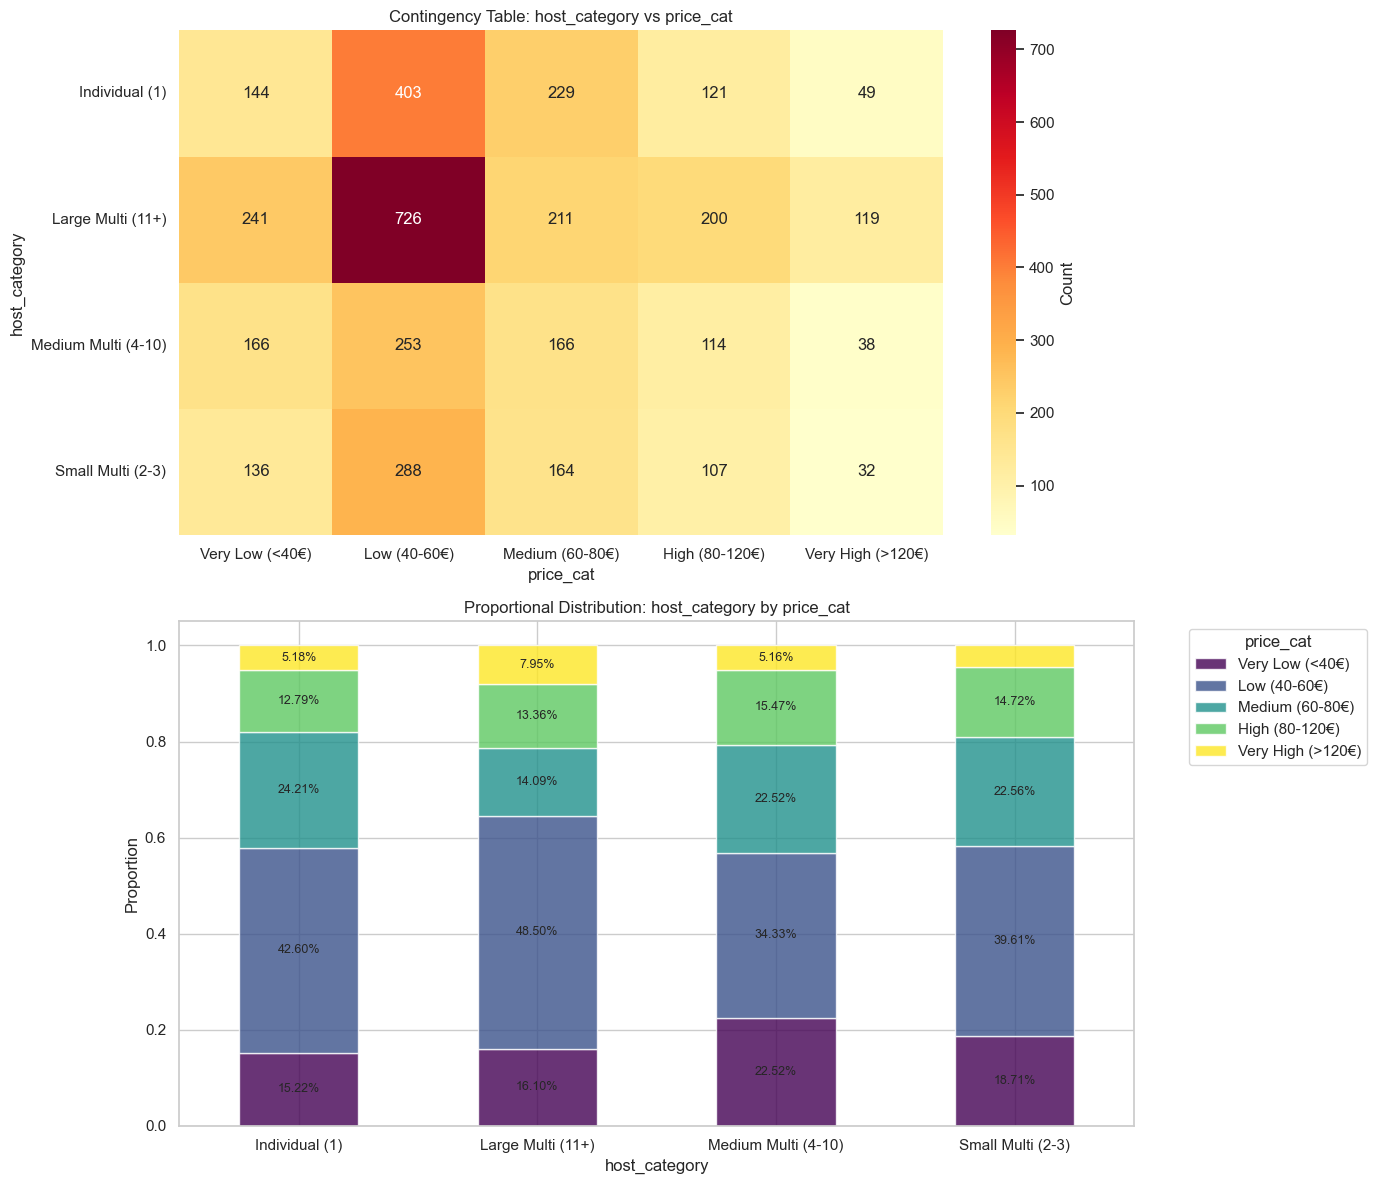

CHI-SQUARE TEST OF INDEPENDENCE: host_category vs price_cat

Contingency Table:
price_cat            Very Low (<40€)  Low (40-60€)  Medium (60-80€)  \
host_category                                                         
Individual (1)                   144           403              229   
Large Multi (11+)                241           726              211   
Medium Multi (4-10)              166           253              166   
Small Multi (2-3)                136           288              164   

price_cat            High (80-120€)  Very High (>120€)  
host_category                                           
Individual (1)                  121                 49  
Large Multi (11+)               200                119  
Medium Multi (4-10)             114                 38  
Small Multi (2-3)               107                 32  

Test Statistics:
  Chi-square statistic: 97.7596
  Degrees of freedom:   12
  P-value:              0.000000
  Cramér's V:           0.091
  Effect si

In [89]:
for var in variables:
    
    if pd.api.types.is_numeric_dtype(df[var]):
        
        analyze_numeric_variable(df[var])
        analyze_categorical_numerical(df["host_category"], df[var])

    else:
        
        analyze_categorical_variable(df[var])
        analyze_categorical_categorical(df["host_category"], df[var])

    print("\n", "\n")